## An Evaluation of the Impact of Leading Pedestrian Interval Signals in NYC


<br><br>

By
<br><br>
Jeremy J. Sze
<br><br>


Submitted in partial fulfillment<br>
of the requirements for the degree of<br>
Master of Arts in Economics, Hunter College<br>
The City University of New York<br>
2019

<br><br>

Thesis Sponsor: <br>
    Professor Jonathan Conning <br>   
    Professor Partha Deb
    


### Abstract

<p style='text-align: justify;'> 
I evaluated the impact of the phased introduction of Leading Pedestrian Interval Signals (LPIs) on collision and injury outcomes at 12,987 signalized traffic intersections in New York City over the course of 25 quarters from 2012 to 2018. An intersection is treated when a LPIs is installed to give pedestrians lead time to cross the street before vehicles are allowed to move. Outcomes from NYPD’s Motor Vehicle Collisions data were matched to signalized intersections. I hypothesize that LPIs would reduce collisions and reduce injuries for pedestrians at intersections. A difference in difference fixed effects panel regression was used to identify the causal effect of introducing LPIs. This approach accounts for the problem that unobserved heterogeneity that might bias results in simpler regression approaches. The analysis suggests that the introduction of LPIs decreased quarterly collision counts by 5.45% and decreased the quarterly number of pedestrians injured by 14.7% over the same intervention period. LPIs appears to be effective in reducing both collisions and injuries.
</p>

### Acknowledgements
<p style='text-align: justify;'>
Throughout the analysis and writing of my thesis I had received a great deal of support and assistance. I would like to thank my thesis advisor, Professor Jonathan Conning, who helped me develop my data processing pipeline and analytical plan. Next, I would like to thank Professor Partha Deb and Professor Matthew Baker for their valuable time and input during the model development stage and Professor Randall Filer for his guidance in the bi-weekly thesis workshops. In addition, I would like to thank my sister, Jocelyne Sze and friend Dennis Kim for proofreading my thesis drafts. Finally, I would like to thank my wife, Maria Eugenia Brandão for her wise counsel and support as we discussed ideas for my thesis. 
</p>

### Contents

1. Signal intersection (stata)
2. LPIs (python)
3. Linking Signal intersection to other data (python)
4. NYPD Motor Vehicle Collision data
    - download (stata)
    - clean (stata)
    - link to signal intersection (python)
5. Calculate collision outcomes (stata)
6. Set up panel data
    - monthly analytical panel (stata)
    - quarterly analytical panel (stata)
7. Convert analytical panel data into shapefile (python)
8. Thiessen Polygons (python)
9. Non-spatial Analysis (stata)
10. Spatial Analysis (stata)

### 1. Signal intersection
- Stata
- Explore duplicates
- Create intersection IDS

#### About "signal_controllers.csv"
This was obtained through a request to the DOT Commissioner.

In [1]:
cd "..\input_data\DOT_traffic_signals_Oct_2018\"

C:\Users\jerem\Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018


In [2]:
import delimited using "signal_controllers.csv",clear stringcols(_all)

(6 vars, 13,278 obs)


In [4]:
describe


Contains data
  obs:        13,278                          
 vars:             7                          
 size:     2,376,762                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
y               str22   %22s                  Y
x               str22   %22s                  X
st1_name        str31   %31s                  ST1_Name
st2_name        str32   %32s                  ST2_Name
st3_name        str35   

In [3]:
duplicates tag y x, gen(dup)
tab dup



Duplicates in terms of y x


        dup |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |     13,156       99.08       99.08
          1 |        112        0.84       99.92
          2 |          3        0.02       99.95
          6 |          7        0.05      100.00
------------+-----------------------------------
      Total |     13,278      100.00


In [5]:
duplicates drop y x, force


Duplicates in terms of y x

(64 observations deleted)


In [7]:
gen intersection_id = _n, before(y)

Check to remember why we dropped intersection_id 2799

In [8]:
// Nonsensical coordinates
drop if intersection_id ==  2799

(1 observation deleted)


In [ ]:
save "signal_controllers_clean.dta"

### 2. Leading Pedestrian Interval Signals (LPIs) 
- Python
- Explore the LPIs data using python's Geopandas library
- Create IDs
- Save into Stata dta

In [511]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point, MultiPoint
import pysal as ps
import libpysal
from libpysal.cg.voronoi  import voronoi, voronoi_frames

from pysal.contrib.viz import mapping as map
from pylab import *
from pysal.contrib.viz import folium_mapping as fm
import geojson as gj
import seaborn as sns
import mplleaflet as mpll

%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [10]:
cd

C:\Users\jerem


Opening the Vision Zero Leading Pedestrian Interval Signals shapefile

In [19]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\VZV_Leading Pedestrian Interval Signals\geo_export_0c63b43f-83c0-4834-aa91-2c564c1bff2c.shp"

In [20]:
lpis_df = gpd.read_file(fp)

In [21]:
lpis_df.head(3)

cross_stre  date_insta    time_insta        lat       long  \
0  Dreiser loop East  2018-08-01  00:00:00.000  40.878465 -73.828273   
1        West 119 St  2018-08-08  00:00:00.000  40.803958 -73.948271   
2        West 120 St  2018-08-08  00:00:00.000  40.804587 -73.947812   

        main_stree                                      geometry  
0  Co-op City Blvd  POINT (-73.82827338235253 40.87846542795222)  
1     Lenox Avenue  POINT (-73.94827133431397 40.80395846158952)  
2     Lenox Avenue  POINT (-73.94781210658503 40.80458679730486)

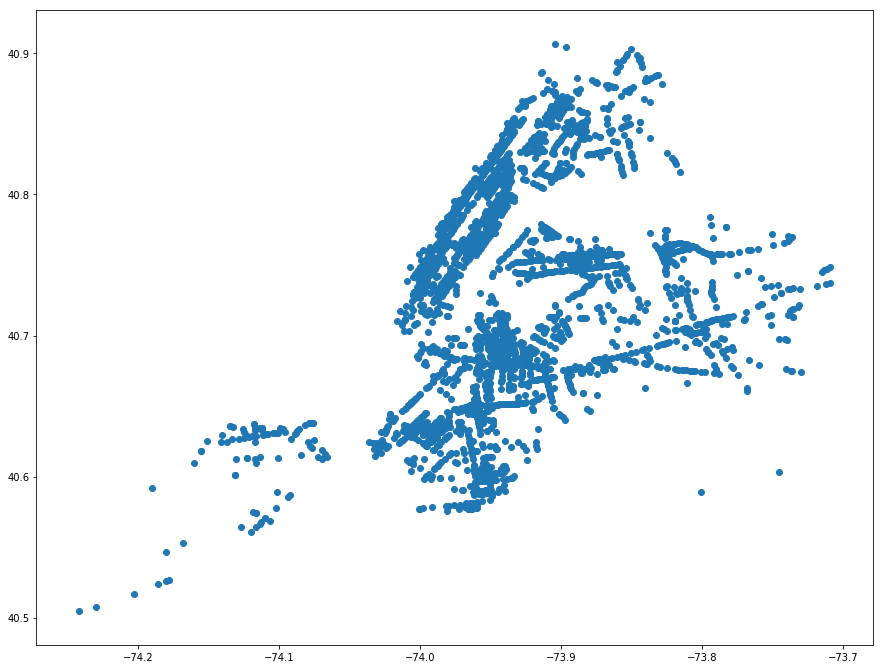

In [22]:
lpis_df.plot(figsize=(15, 15));

First, we have to check the CRS (coordinate reference system)  of the shapefile. This is important because all the other shapefiles have to be on the same projection in order to do spatial joins and identify nearest neighbors. For more information on projections, you can watch this [short video](https://youtu.be/KUF_Ckv8HbE) and read this [document](https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/) from [Earthdatascience.org](https://www.earthdatascience.org).


To see the crs of lpis_df, we use geodataframe.crs

In [23]:
lpis_df.crs

{'init': 'epsg:4326'}

EPSG 4326 is the coordinate system for the world. It is also known as WGS84. When you have a longitude and latitude from this CRS, you can copy and paste it into Google Maps to find that location. 

Since we are working with New York City only, we prefer to use a projection that more accurately protrays the shape of NYC. We will reproject lpis_df to EPSG 2263 (NAD83 / New York Long Island (ftUS)).

In [24]:
lpis_df = lpis_df.to_crs({'init': 'epsg:2263'})

We can see that lpis_df now has the right projection.

In [25]:
lpis_df.crs

{'init': 'epsg:2263'}

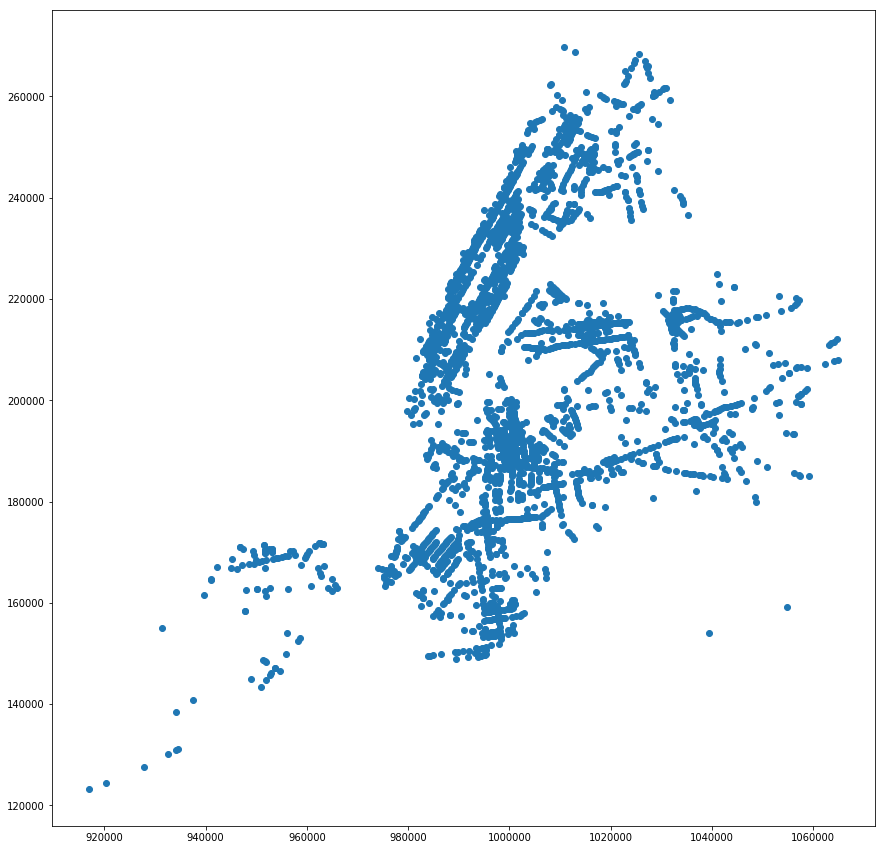

In [26]:
lpis_df.plot(figsize=(15, 15));

If you look at both plots again, you will notice that the axes labels are different. This is due to the different CRS.

I create IDs in the dataframe, since lpis_df has no ID variables.

In [27]:
lpis_df['LPIS_ID'] = lpis_df.index
lpis_df.head(3)

cross_stre  date_insta    time_insta        lat       long  \
0  Dreiser loop East  2018-08-01  00:00:00.000  40.878465 -73.828273   
1        West 119 St  2018-08-08  00:00:00.000  40.803958 -73.948271   
2        West 120 St  2018-08-08  00:00:00.000  40.804587 -73.947812   

        main_stree                                     geometry  LPIS_ID  
0  Co-op City Blvd   POINT (1031739.000154228 259373.000004255)        0  
1     Lenox Avenue  POINT (998570.9998893011 232184.9999184268)        1  
2     Lenox Avenue  POINT (998697.9999633889 232414.0001165908)        2

Next, I want to export the dataframe to a Stata dta file. Objects need to be converted to str. 

In [24]:
# Might be unnecessary
#str_cols = list(lpis_df.select_dtypes(include=['object']).columns)
#for col in str_cols:
#    lpis_df[col] = lpis_df[col].astype(str)

In [ ]:
#fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\VZV_LPIS_data.dta"
#lpis_df.to_stata(fp)

### 3. Linking Signal intersection to other data
- python
- uses scipy's cKDTree 
- connects each data to the nearest signal intersection

Define a function to obtain IDs of nearest neighbors and distance measure.

In [28]:
# ckdnearest function
# from "https://gist.github.com/jhconning/63a34a51acff83d116adc52308faf240"
def ckdnearest(gdA, gdB, bcol):
    """
    This function takes geodataframes: `gdA` and `gdB` and 
    a column name `bcol`. Both dataframes are assumed to have a `geometry` column. 
    It finds the nearest neighbor from each location in `gdA` to a 
    nearest neighbor in `gdB`.  

    It returns a two-column pandas dataframe with a 'distance' (here rounded to nearest foot)
    and the value of the `bcol` in `gdB'  (e.g. 'school_name')
    """
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(int),
                             'bcol' : gdB.loc[idx, bcol].values })
    return df

#### 3.a. Signal Intersections
Read the cleaned Signal intersection Stata dta file

In [3]:
# Open signal intersection stata dta file
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018\signal_controllers_clean.dta"

In [4]:
sig_inters_df = pd.read_stata(fp)

In [5]:
sig_inters_df.head(3)

intersection_id                 y                 x  \
0              1.0  199793.609300002        986336.149   
1              2.0  202206.161899999        982769.331   
2              3.0       201790.0942  982805.618399993   

                 st1_name          st2_name       st3_name st4_name  dup  
0            ALLEN STREET      CANAL STREET                            0  
1  AVENUE OF THE AMERICAS     LAIGHT STREET   CANAL STREET             0  
2  AVENUE OF THE AMERICAS  LISPENARD STREET  WEST BROADWAY             0

In [8]:
sig_inters_df['y'].dtypes

dtype('O')

In [9]:
sig_inters_df['x'].dtypes

dtype('O')

Convert the y and x coordinates into float

In [11]:
# Convert coordinates into float
sig_inters_df['y'] = sig_inters_df['y'].astype(float)
sig_inters_df['x'] = sig_inters_df['x'].astype(float)

Create Coordinates by combining x and y together with zip into a list

In [14]:
sig_inters_df['Coordinates'] = list(zip(sig_inters_df.x, sig_inters_df.y))

Turn Coordinates into shapely Points

In [16]:
sig_inters_df['Coordinates'] = sig_inters_df['Coordinates'].apply(Point)

Create Geopandas dataframe

In [17]:
sig_inters_gdf = gpd.GeoDataFrame(sig_inters_df, geometry='Coordinates')

#### 3.b. Leading Pedestrian Signal Interval

In [29]:
lpis_df.head(3)

cross_stre  date_insta    time_insta        lat       long  \
0  Dreiser loop East  2018-08-01  00:00:00.000  40.878465 -73.828273   
1        West 119 St  2018-08-08  00:00:00.000  40.803958 -73.948271   
2        West 120 St  2018-08-08  00:00:00.000  40.804587 -73.947812   

        main_stree                                     geometry  LPIS_ID  
0  Co-op City Blvd   POINT (1031739.000154228 259373.000004255)        0  
1     Lenox Avenue  POINT (998570.9998893011 232184.9999184268)        1  
2     Lenox Avenue  POINT (998697.9999633889 232414.0001165908)        2

For each LPIs, we want to find the closest signalized intersection

In [30]:
sig_inters_gdf[['distance_to_LPIS','nearest_LPIS']] = ckdnearest(sig_inters_gdf, lpis_df,'LPIS_ID')

In [31]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  nearest_LPIS  
0    POINT (986336.149 199793.609300002)               276          1915  
1    POINT (982769.331 202206.161899999)               592          2016  
2  POINT (982805.6183999931 201790.0942)               413          2016

See the number of observations in sig_inters_gdf

In [32]:
sig_inters_gdf['intersection_id'].count()

13213

We want to merge into sig_inters_gdf additional information from lpis_df

In [33]:
sig_inters_gdf = sig_inters_gdf.merge(lpis_df[['date_insta','LPIS_ID']], how='left', left_on='nearest_LPIS', right_on='LPIS_ID', validate ="m:1")

In [34]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  nearest_LPIS  \
0    POINT (986336.149 199793.609300002)               276          1915   
1    POINT (982769.331 202206.161899999)               592          2016   
2  POINT (982805.6183999931 201790.0942)               413          2016   

   date_insta  LPIS_ID  
0  2015-10-16     1915  
1  1997-08-07     2016  
2  1997-08-07     2016

Remove the additional variable LPIS_ID

In [35]:
sig_inters_gdf.drop(['LPIS_ID'], axis=1, inplace=True)

#### 3.c. School shapefile
source: https://www.baruch.cuny.edu/confluence/display/geoportal/NYC+Geodatabase

In [36]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\school_private_public_2263\school_private_public_2263.shp"

In [37]:
school_gdf = gpd.read_file(fp)

In [38]:
school_gdf.head(3)

uid      idagency                    facname                     opname  \
0   192.0  321000145390  Our Lady Of Refuge School  Our Lady Of Refuge School   
1   294.0  332000226225   Yeshiva Toldos Yesuscher   Yeshiva Toldos Yesuscher   
2  2233.0  331400225670                Ohel Elozer                Ohel Elozer   

                  address      city zipcode  bcode                facsubgrp  \
0      2708 Briggs Avenue     Bronx   10458  36005  Non-Public K-12 Schools   
1          1531 63 Street  Brooklyn   11219  36047  Non-Public K-12 Schools   
2  263 Classon Ave-Ste 4b  Brooklyn   11205  36047  Non-Public K-12 Schools   

                          factype  capacity   util        xcoord       ycoord  \
0  Elementary School - Non-public       NaN  267.0  1.014359e+06  254977.5176   
1  Elementary School - Non-public       NaN   74.0  9.857114e+05  166689.5140   
2        High School - Non-public       NaN  161.0  9.951838e+05  191390.1394   

                           geometry  
0  POINT (1014358.6833 254977.5176)  
1    POINT (985711.4182 166689.514)  
2    POINT (995183.844 191390.1394)

In [39]:
school_gdf.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

For each school, we want to find the closest signalized intersection

In [40]:
sig_inters_gdf[['distance_to_Sch','nearest_Sch']] = ckdnearest(sig_inters_gdf, school_gdf,'uid')

In [41]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  nearest_LPIS  \
0    POINT (986336.149 199793.609300002)               276          1915   
1    POINT (982769.331 202206.161899999)               592          2016   
2  POINT (982805.6183999931 201790.0942)               413          2016   

   date_insta  distance_to_Sch  nearest_Sch  
0  2015-10-16              529       3433.0  
1  1997-08-07              795      38150.0  
2  1997-08-07              635      38150.0

#### 3.d. Vision Zero Left Turn Calming intervention

In [42]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\left_turn_traffic_calming_shapefile\left_turn_traffic_calming.shp"

In [43]:
ltc_gdf = gpd.read_file(fp)

In [44]:
ltc_gdf.head(3)

treatment_  completion  \
0                               Quick Kurb to X-walk  2017-12-08   
1  Daylighting, Box markings, (1) 6' Rubber speed...  2018-04-12   
2                               Quick Kurb to X-walk  2016-06-30   

                                       geometry  
0  POINT (-73.97604825017703 40.75144139179798)  
1  POINT (-73.82577379991478 40.75635805716421)  
2   POINT (-73.97719688637932 40.7643236906894)

In [46]:
ltc_gdf.crs

{'init': 'epsg:4326'}

We have to reproject the geodataframe to the right CRS (EPSG 2263: NAD83 / New York Long Island (ftUS))

In [47]:
ltc_gdf = ltc_gdf.to_crs({'init': 'epsg:2263'})

Create ID variable for ltc_gdf

In [48]:
ltc_gdf['LTC_ID'] = ltc_gdf.index

In [49]:
ltc_gdf.head(3)

treatment_  completion  \
0                               Quick Kurb to X-walk  2017-12-08   
1  Daylighting, Box markings, (1) 6' Rubber speed...  2018-04-12   
2                               Quick Kurb to X-walk  2016-06-30   

                                      geometry  LTC_ID  
0   POINT (990886.2363875993 213047.939427546)       0  
1  POINT (1032518.714146682 214886.3347008746)       1  
2  POINT (990566.7655698524 217741.2961825352)       2

For each left turn calming intervention, we want to find the closest signalized intersection

In [50]:
sig_inters_gdf[['distance_to_LTC','nearest_LTC']] = ckdnearest(sig_inters_gdf, ltc_gdf,'LTC_ID')

In [51]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  nearest_LPIS  \
0    POINT (986336.149 199793.609300002)               276          1915   
1    POINT (982769.331 202206.161899999)               592          2016   
2  POINT (982805.6183999931 201790.0942)               413          2016   

   date_insta  distance_to_Sch  nearest_Sch  distance_to_LTC  nearest_LTC  
0  2015-10-16              529       3433.0             1183          191  
1  1997-08-07              795      38150.0              411           77  
2  1997-08-07              635      38150.0              790           77

We want to merge into sig_inters_gdf additional information from ltc_gdf

In [52]:
sig_inters_gdf = sig_inters_gdf.merge(ltc_gdf[['treatment_', 'completion', 'LTC_ID']], how='left', left_on='nearest_LTC', right_on='LTC_ID', validate ="m:1")

In [53]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  nearest_LPIS  \
0    POINT (986336.149 199793.609300002)               276          1915   
1    POINT (982769.331 202206.161899999)               592          2016   
2  POINT (982805.6183999931 201790.0942)               413          2016   

   date_insta  distance_to_Sch  nearest_Sch  distance_to_LTC  nearest_LTC  \
0  2015-10-16              529       3433.0             1183          191   
1  1997-08-07              795      38150.0              411           77   
2  1997-08-07              635      38150.0              790           77   

                                          treatment_  completion  LTC_ID  
0  Daylighting, Box markings, Pegatracks, Delinea...  2017-12-08     191  
1                               Quick Kurb to x-walk  2017-12-08      77  
2                               Quick Kurb to x-walk  2017-12-08      77

In [55]:
sig_inters_gdf.drop(['LTC_ID'], axis=1, inplace=True)

#### 3.e. Vision Zero Street Improvement

In [57]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\street_improvement_proj_intersections_point\street_improvement_proj_intersections_point.shp"

In [58]:
sip_gdf = gpd.read_file(fp)

In [59]:
sip_gdf.head(3)

Pjct_Name  SIP_YR  DateComplt  \
0  Jackson Avenue at Pulaski Bridge    2009  2009-07-31   
1           12th Ave at W. 135th St    2009  2009-05-09   
2        Flatbush Ave at Church Ave    2009  2009-09-25   

                                 SIPProjTyp  \
0                                         -   
1  Traffic Network Chng - Pedestrian Safety   
2         Pedestrian Safety - School Safety   

                                      geometry  
0  POINT (997734.4838460496 210053.6281589993)  
1  POINT (995894.2742718621 238501.8740837589)  
2   POINT (995708.027925191 176232.7026909116)

In [60]:
sip_gdf.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

We have to reproject the geodataframe to the right CRS (EPSG 2263: NAD83 / New York Long Island (ftUS))

In [63]:
sip_gdf = sip_gdf.to_crs({'init': 'epsg:2263'})

In [64]:
sip_gdf.crs

{'init': 'epsg:2263'}

Create ID variable for sip_gdf

In [65]:
sip_gdf['StImpro_ID'] = sip_gdf.index

In [66]:
sip_gdf.head(3)

Pjct_Name  SIP_YR  DateComplt  \
0  Jackson Avenue at Pulaski Bridge    2009  2009-07-31   
1           12th Ave at W. 135th St    2009  2009-05-09   
2        Flatbush Ave at Church Ave    2009  2009-09-25   

                                 SIPProjTyp  \
0                                         -   
1  Traffic Network Chng - Pedestrian Safety   
2         Pedestrian Safety - School Safety   

                                      geometry  StImpro_ID  
0  POINT (997734.4838460496 210053.6281589342)           0  
1  POINT (995894.2742718621 238501.8740837032)           1  
2   POINT (995708.027925191 176232.7026908512)           2

For each street improvement project, we want to find the closest signalized intersection

In [67]:
sig_inters_gdf[['distance_to_StImpro','nearest_StImpro']] = ckdnearest(sig_inters_gdf, sip_gdf,'StImpro_ID')

We want to merge into sig_inters_gdf additional information from sip_gdf

In [68]:
sig_inters_gdf = sig_inters_gdf.merge(sip_gdf[['DateComplt', 'SIPProjTyp', 'StImpro_ID']], 
                                      how='left', 
                                      left_on='nearest_StImpro', 
                                      right_on='StImpro_ID', 
                                      validate ="m:1")

In [69]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  ...  nearest_Sch  \
0    POINT (986336.149 199793.609300002)               276  ...       3433.0   
1    POINT (982769.331 202206.161899999)               592  ...      38150.0   
2  POINT (982805.6183999931 201790.0942)               413  ...      38150.0   

  distance_to_LTC  nearest_LTC  \
0            1183          191   
1             411           77   
2             790           77   

                                          treatment_  completion  \
0  Daylighting, Box markings, Pegatracks, Delinea...  2017-12-08   
1                               Quick Kurb to x-walk  2017-12-08   
2                               Quick Kurb to x-walk  2017-12-08   

   distance_to_StImpro nearest_StImpro  DateComplt  \
0                  272               4  2009-10-31   
1                 2101             245  2016-07-23   
2                 2098             245  2016-07-23   

                          SIPProjTyp  StImpro_ID  
0                                  -           4  
1  VZ Priority Geo - Traffic Calming         245  
2  VZ Priority Geo - Traffic Calming         245  

[3 rows x 23 columns]

In [70]:
sig_inters_gdf.drop(['StImpro_ID'], axis=1, inplace=True)

#### 3.f. Bike Routes

In [71]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\bike_routes_points_2263\bike_routes_points_2263.shp"

In [72]:
br_gdf = gpd.read_file(fp)

In [73]:
br_gdf.head(3)

tf_facilit comments bikedir ft_facilit  objectid_1 allclasses  \
0  Protected Path     None       L       None         1.0          I   
1  Protected Path     None       L       None         1.0          I   
2  Protected Path     None       L       None         1.0          I   

  date_instd    time_instd  lanecount segment_id  boro street date_modda  \
0       None  00:00:00.000        1.0      33547   1.0   9 AV       None   
1       None  00:00:00.000        1.0      33547   1.0   9 AV       None   
2       None  00:00:00.000        1.0      33547   1.0   9 AV       None   

     time_modda tostreet fromstreet onoffst  \
0  00:00:00.000  W 31 ST    W 16 ST      ON   
1  00:00:00.000  W 31 ST    W 16 ST      ON   
2  00:00:00.000  W 31 ST    W 16 ST      ON   

                                      geometry  
0   POINT (984139.5802614246 211708.657997195)  
1  POINT (984140.0661334711 211709.5320271455)  
2  POINT (984140.5520055175 211710.4060570961)

In [74]:
br_gdf.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [75]:
br_gdf = br_gdf.to_crs({'init': 'epsg:2263'})

In [76]:
sig_inters_gdf[['distance_to_bikeroute','nearest_bikeroute']] = ckdnearest(sig_inters_gdf, br_gdf,'objectid_1')

In [77]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  ...  \
0    POINT (986336.149 199793.609300002)               276  ...   
1    POINT (982769.331 202206.161899999)               592  ...   
2  POINT (982805.6183999931 201790.0942)               413  ...   

   distance_to_LTC nearest_LTC  \
0             1183         191   
1              411          77   
2              790          77   

                                          treatment_  completion  \
0  Daylighting, Box markings, Pegatracks, Delinea...  2017-12-08   
1                               Quick Kurb to x-walk  2017-12-08   
2                               Quick Kurb to x-walk  2017-12-08   

   distance_to_StImpro  nearest_StImpro  DateComplt  \
0                  272                4  2009-10-31   
1                 2101              245  2016-07-23   
2                 2098              245  2016-07-23   

                          SIPProjTyp  distance_to_bikeroute  nearest_bikeroute  
0                                  -                      3             8553.0  
1  VZ Priority Geo - Traffic Calming                    230             1778.0  
2  VZ Priority Geo - Traffic Calming                      1             1769.0  

[3 rows x 24 columns]

#### 3.g. Borough

In [78]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\nyc_boroughs_2263\nyc_boroughs_2263.shp"

In [79]:
borough_gdf = gpd.read_file(fp)

In [81]:
borough_gdf.head()

bcode          bname      name         namelsad  \
0  36005          Bronx     Bronx     Bronx County   
1  36047       Brooklyn     Kings     Kings County   
2  36061      Manhattan  New York  New York County   
3  36081         Queens    Queens    Queens County   
4  36085  Staten Island  Richmond  Richmond County   

                                            geometry  
0  (POLYGON ((1008982.068976385 272752.8735210547...  
1  (POLYGON ((978869.3811487257 186863.7807399245...  
2  (POLYGON ((1007701.483091666 258286.8905491272...  
3  (POLYGON ((1026830.772887008 155435.7100568501...  
4  (POLYGON ((930721.1281812892 156627.9162643671...

In [82]:
borough_gdf.crs = sig_inters_gdf.crs

In [83]:
sig_inters_gdf = gpd.sjoin(sig_inters_gdf,borough_gdf[['bname', 'geometry']], how='left', op='intersects')

In [84]:
sig_inters_gdf.drop('index_right', axis=1, inplace=True)

In [85]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  ...  nearest_LTC  \
0    POINT (986336.149 199793.609300002)               276  ...          191   
1    POINT (982769.331 202206.161899999)               592  ...           77   
2  POINT (982805.6183999931 201790.0942)               413  ...           77   

                                          treatment_  completion  \
0  Daylighting, Box markings, Pegatracks, Delinea...  2017-12-08   
1                               Quick Kurb to x-walk  2017-12-08   
2                               Quick Kurb to x-walk  2017-12-08   

   distance_to_StImpro  nearest_StImpro  DateComplt  \
0                  272                4  2009-10-31   
1                 2101              245  2016-07-23   
2                 2098              245  2016-07-23   

                          SIPProjTyp distance_to_bikeroute  nearest_bikeroute  \
0                                  -                     3             8553.0   
1  VZ Priority Geo - Traffic Calming                   230             1778.0   
2  VZ Priority Geo - Traffic Calming                     1             1769.0   

       bname  
0  Manhattan  
1  Manhattan  
2  Manhattan  

[3 rows x 25 columns]

#### 3.h. Priority Intersections

In [86]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\vz_priority_intersections_shapefile\vz_priority_intersections_shapefile\vz_priority_intersections.shp"

In [87]:
pi_gdf = gpd.read_file(fp)

In [88]:
pi_gdf.crs

{'init': 'epsg:4326'}

In [89]:
pi_gdf = pi_gdf.to_crs({'init': 'epsg:2263'})

In [90]:
pi_gdf['priority_inters_ID'] = pi_gdf.index

In [91]:
sig_inters_gdf[['distance_to_priorityinters','nearest_priorityinters']] = ckdnearest(sig_inters_gdf, pi_gdf,'priority_inters_ID')

In [92]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  ...  completion  \
0    POINT (986336.149 199793.609300002)               276  ...  2017-12-08   
1    POINT (982769.331 202206.161899999)               592  ...  2017-12-08   
2  POINT (982805.6183999931 201790.0942)               413  ...  2017-12-08   

  distance_to_StImpro  nearest_StImpro  DateComplt  \
0                 272                4  2009-10-31   
1                2101              245  2016-07-23   
2                2098              245  2016-07-23   

                          SIPProjTyp  distance_to_bikeroute nearest_bikeroute  \
0                                  -                      3            8553.0   
1  VZ Priority Geo - Traffic Calming                    230            1778.0   
2  VZ Priority Geo - Traffic Calming                      1            1769.0   

       bname  distance_to_priorityinters  nearest_priorityinters  
0  Manhattan                           7                     245  
1  Manhattan                        2289                     191  
2  Manhattan                        2331                     191  

[3 rows x 27 columns]

#### 3.i. Safe Streets for Seniors

In [93]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\safe_streets_for_seniors_shapefile\safe_streets_for_seniors.shp"

In [94]:
seniors_gdf = gpd.read_file(fp)

In [95]:
seniors_gdf.crs

{'init': 'epsg:4326'}

In [96]:
seniors_gdf = seniors_gdf.to_crs({'init': 'epsg:2263'})

In [97]:
seniors_gdf['seniors_ID'] = seniors_gdf.index

In [98]:
seniors_gdf.crs = sig_inters_gdf.crs

Spatial Join to identify intersections within Senior Zones

In [99]:
sig_inters_gdf = gpd.sjoin(sig_inters_gdf, seniors_gdf[['Name', 'seniors_ID','geometry']], how='left', op='within')

In [100]:
sig_inters_gdf.drop('index_right', axis=1, inplace=True)

In [101]:
sig_inters_gdf.head(3)

intersection_id            y            x                st1_name  \
0              1.0  199793.6093  986336.1490            ALLEN STREET   
1              2.0  202206.1619  982769.3310  AVENUE OF THE AMERICAS   
2              3.0  201790.0942  982805.6184  AVENUE OF THE AMERICAS   

           st2_name       st3_name st4_name  dup  \
0      CANAL STREET                            0   
1     LAIGHT STREET   CANAL STREET             0   
2  LISPENARD STREET  WEST BROADWAY             0   

                             Coordinates  distance_to_LPIS  ...  \
0    POINT (986336.149 199793.609300002)               276  ...   
1    POINT (982769.331 202206.161899999)               592  ...   
2  POINT (982805.6183999931 201790.0942)               413  ...   

   nearest_StImpro  DateComplt                         SIPProjTyp  \
0                4  2009-10-31                                  -   
1              245  2016-07-23  VZ Priority Geo - Traffic Calming   
2              245  2016-07-23  VZ Priority Geo - Traffic Calming   

   distance_to_bikeroute  nearest_bikeroute      bname  \
0                      3             8553.0  Manhattan   
1                    230             1778.0  Manhattan   
2                      1             1769.0  Manhattan   

  distance_to_priorityinters nearest_priorityinters             Name  \
0                          7                    245  Lower East Side   
1                       2289                    191              NaN   
2                       2331                    191              NaN   

   seniors_ID  
0        27.0  
1         NaN  
2         NaN  

[3 rows x 29 columns]

In [102]:
str_cols = list(sig_inters_gdf.select_dtypes(include=['object']).columns)
for col in str_cols:
    sig_inters_gdf[col] = sig_inters_gdf[col].astype(str)

In [103]:
fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\signal_intersection.dta"

In [ ]:
#sig_inters_gdf.to_stata(fp)

### 4. NYPD Motor Vehicle Collision data

#### 4.a. download 
- stata

In [104]:
clear

In [105]:
import delimited "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"

(29 vars, 1,482,622 obs)


In [106]:
notes: "Downloaded $S_DATE $S_TIME"
notes list




_dta:
  1.  "Downloaded 25 Apr 2019 10:52:22"


`save` is commented out so I do not replace my original dataset

In [ ]:
//save "..\input_data\NYPD_Motor_Vehicle_Collisions.dta"

#### 4.b. clean 
- stata

In [233]:
use "..\input_data\NYPD_Motor_Vehicle_Collisions.dta",clear

In [234]:
notes list 
//Check that notes is "Downloaded 28 Sep 2018 15:48:00"


_dta:
  1.  "Downloaded 28 Sep 2018 15:48:00"


Formatting the data

In [235]:
%head

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  1. |       date |  time |       borough | zipcode | latitude | longitude |                location |                     onstreetname | crossstreetn~e |                            offstreetname | number.. | number.. | number.. | number.. | number.. |
     | 09/24/2018 |  0:00 | STATEN ISLAND |   10306 | 40.57322 | -74.10699 |  (40.57322, -74.106995) | HYLAN BOULEVARD                  |    OTIS AVENUE |                                          |        0 |        0 |        0 |        0 |        0 |
     |---------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
     | number..  | number..  | number..  |     contributingfactorvehicle1  |     contributingfactorvehicle2  | contri~3  | contri~4  |  contri~5  |  unique~y  |                     vehicletypecode1  |  vehicl~2  |  vehicl~3  |  vehicl~4  |  vehicl~5  |
     |        0  |        0  |        0  | Driver Inattention/Distraction  |                    Unspecified  |           |           |            |   3987045  |  Station Wagon/Sport Utility Vehicle  |     Sedan  |            |            |            |
     +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

     +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  2. |       date |  time |       borough | zipcode | latitude | longitude |                location |                     onstreetname | crossstreetn~e |                            offstreetname | number.. | number.. | number.. | number.. | number.. |
     | 09/24/2018 |  0:00 |               |         | 40.61261 | -74.07696 |  (40.612614, -74.07696) | FLETCHER STREET                  |                |                                          |        0 |        0 |        0 |        0 |        0 |
     |---------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
     | number..  | number..  | number..  |     contributingfactorvehicle1  |     contributingfactorvehicle2  | contri~3  | contri~4  |  contri~5  |  unique~y  |                     vehicletypecode1  |  vehicl~2  |  vehicl~3  |  vehicl~4  |  vehicl~5  |
     |        0  |        0  |        0  | Driver Inattention/Distraction  |                    Unspecified  |           |           |            |   3987187  |  Station Wagon/Sport Utility Vehicle  |     Sedan  |            |            |            |
     +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

     +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  3. |       date |  time |       borough | zipcode | latitude | longitude |                location |                     onstreetname | crossstreetn~e |                            offstreetname | number.. |

In [236]:
order(uniquekey), before(date)

Create dates that are in the Stata internal form(SIF) that Stata can understand

In [237]:
codebook date


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
date                                                                                                                                                                                                                                                       DATE
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  string (str105)

         unique values:  2,278                    missing "":  0/1,351,215

              examples:  "03/22/2016"
                         "06/05/2015"
                         "08/10/2015

The date variable is a string in the format of month day and year. Therefore, we will use Stata's mask MDY to create the date in SIF.

In [238]:
gen date2 = date(date, "MDY"),after(date)
format date2 %td


(1 missing value generated)



There is an observation with nonsensical values in the date str variable

In [239]:
drop date
rename date2 date

In [240]:
gen time2 = clock(time, "hm"),after(time)
format time2 %tcHH:MM
drop time
rename time2 time


(1 missing value generated)





We can easily extract year from SIF data

In [241]:
gen year = year(date), before(date)

(1 missing value generated)


Create latenight indicator variable

In [242]:
gen latenight = (time > tc(23:00:00) & time <= tc(23:59:59)) | (time >= tc(00:00:00) & time < tc(05:00:00)), after(time)

In [243]:
tab latenight


  latenight |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |  1,218,191       90.16       90.16
          1 |    133,024        9.84      100.00
------------+-----------------------------------
      Total |  1,351,215      100.00


Rename long variable names

In [244]:
rename numberofpersonsinjured personsinjured
rename numberofpersonskilled personskilled
rename numberofpedestriansinjured pedestriansinjured
rename numberofpedestrianskilled pedestrianskilled
rename numberofcyclistinjured cyclistinjured
rename numberofcyclistkilled cyclistkilled
rename numberofmotoristinjured motoristinjured
rename numberofmotoristkilled motoristkilled

Create an indicator for observations with missing Longditude and Latitude points

In [245]:
gen mi_latlong = mi(latitude) & mi(longitude), after(longitude)

In [246]:
tab mi_latlong year, column


+-------------------+
| Key               |
|-------------------|
|     frequency     |
| column percentage |
+-------------------+

           |                                     year
mi_latlong |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    85,450    171,914    172,724    182,956    145,733    212,986    155,901 | 1,127,664 
           |     84.99      84.39      83.84      84.05      63.96      92.84      93.93 |     83.46 
-----------+-----------------------------------------------------------------------------+----------
         1 |    15,089     31,809     33,302     34,731     82,104     16,437     10,078 |   223,550 
           |     15.01      15.61      16.16      15.95      36.04       7.16       6.07 |     16.54 
-----------+-----------------------------------------------------------------------------+----------


Use Stata's `duplicates` command to identify duplicates among onstreetname and crossstreetname

In [247]:
duplicates report onstreetname crossstreetname if ///
!missing(onstreetname) & !missing(crossstreetname)


Duplicates in terms of onstreetname crossstreetname

--------------------------------------
   copies | observations       surplus
----------+---------------------------
        1 |        42735             0
        2 |        42570         21285
        3 |        43125         28750
        4 |        43116         32337
        5 |        40200         32160
        6 |        37398         31165
        7 |        34363         29454
        8 |        32688         28602
        9 |        30033         26696
       10 |        28170         25353
       11 |        26191         23810
       12 |        23868         21879
       13 |        22945         21180
       14 |        21154         19643
       15 |        19485         18186
       16 |        17856         16740
       17 |        16881         15888
       18 |        17046         16099
       19 |        14725         13950
       20 |        14660         13927
       21 |        12810         12200
       22 

      245 |          245           244
      255 |          510           508
      263 |          263           262
      266 |          266           265
      269 |          269           268
      278 |          278           277
      280 |          280           279
      287 |          287           286
      288 |          288           287
      292 |          292           291
      297 |          297           296
      299 |          299           298
      306 |          306           305
      317 |          317           316
      326 |          326           325
      343 |          343           342
      351 |          351           350
      359 |          359           358
      400 |          400           399
      408 |          408           407
    24990 |        24990         24989
--------------------------------------


use Stata's `strtrim` function to remove leading and trailing spaces

In [248]:
replace onstreetname = strtrim(onstreetname)
replace crossstreetname = strtrim(crossstreetname)


(1,079,830 real changes made)

(738,472 real changes made)


In [249]:
sort onstreetname crossstreetname borough zipcode latitude longitude

If borough, zipcode, on street and cross street are the same, we will use the latitude and longitudes for those observations for observations with missing coordinates. s

In [250]:
replace latitude = latitude[_n-1] if ///
mi(latitude) & ///
!mi(latitude[_n-1]) & ///
!mi(borough) & ///
!mi(borough[_n-1]) & ///
!mi(zipcode) & ///
!mi(zipcode[_n-1]) & ///
!mi(onstreetname) & ///
!mi(onstreetname[_n-1]) & ///
!mi(crossstreetname) & ///
!mi(crossstreetname[_n-1]) & ///
(borough == borough[_n-1]) & ///
(zipcode == zipcode[_n-1]) & ///
(onstreetname == onstreetname[_n-1]) & ///
(crossstreetname ==  crossstreetname[_n-1])

replace longitude = longitude[_n-1] if ///
mi(longitude) & ///
!mi(longitude[_n-1]) & ///
!mi(borough) & ///
!mi(borough[_n-1]) & ///
!mi(zipcode) & ///
!mi(zipcode[_n-1]) & ///
!mi(onstreetname) & ///
!mi(onstreetname[_n-1]) & ///
!mi(crossstreetname) & ///
!mi(crossstreetname[_n-1]) & ///
(borough == borough[_n-1]) & ///
(zipcode == zipcode[_n-1]) & ///
(onstreetname == onstreetname[_n-1]) & ///
(crossstreetname ==  crossstreetname[_n-1])


(22,579 real changes made)

(22,579 real changes made)


Create indicator for observations which had their coordinates filled

In [251]:
gen imput_latlong = (mi_latlong ==1 & !mi(latitude) & !mi(longitude)), after(mi_latlong)

In [252]:
tab imput_latlong


imput_latlo |
         ng |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |  1,328,636       98.33       98.33
          1 |     22,579        1.67      100.00
------------+-----------------------------------
      Total |  1,351,215      100.00


Create a second indicator for those observations that still have missing coordinates

In [253]:
gen mi_latlong2 = mi(latitude) & mi(longitude), after(imput_latlong)

In [254]:
tab mi_latlong2 year, column


+-------------------+
| Key               |
|-------------------|
|     frequency     |
| column percentage |
+-------------------+

mi_latlong |                                     year
         2 |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    85,452    171,917    172,730    182,959    164,166    215,363    157,656 | 1,150,243 
           |     84.99      84.39      83.84      84.05      72.05      93.87      94.99 |     85.13 
-----------+-----------------------------------------------------------------------------+----------
         1 |    15,087     31,806     33,296     34,728     63,671     14,060      8,323 |   200,971 
           |     15.01      15.61      16.16      15.95      27.95       6.13       5.01 |     14.87 
-----------+-----------------------------------------------------------------------------+----------


Drop observations whose coordinates fall outside NYC's boundary box

In [255]:
drop if (longitude < -74.5 | longitude > -73) &  !mi(longitude)
drop if (latitude < 40 |  latitude > 41) & !mi(latitude)


(439 observations deleted)

(4 observations deleted)


Drop observations that have missing coordinates

In [256]:
drop if mi_latlong2 == 1

(200,972 observations deleted)


Cross tabulation of missing coordinates by year

In [257]:
tab mi_latlong2 year, column


+-------------------+
| Key               |
|-------------------|
|     frequency     |
| column percentage |
+-------------------+

mi_latlong |                                     year
         2 |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    85,452    171,917    172,730    182,959    164,159    215,211    157,372 | 1,149,800 
           |    100.00     100.00     100.00     100.00     100.00     100.00     100.00 |    100.00 
-----------+-----------------------------------------------------------------------------+----------
     Total |    85,452    171,917    172,730    182,959    164,159    215,211    157,372 | 1,149,800 
           |    100.00     100.00     100.00     100.00     100.00     100.00     100.00 |    100.00 


In [ ]:
//save "..\working_data\NYPD_Motor_Vehicle_Collisions_clean.dta"

#### 4.c. link to signal intersection 
- python

In [258]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\NYPD_Motor_Vehicle_Collisions_clean.dta"
collision_df = pd.read_stata(fp)

In [259]:
collision_df.head(3)

uniquekey    year       date                time  latenight borough  \
0  3427749.0  2016.0 2016-04-24 1960-01-01 18:02:00        0.0           
1  3474445.0  2016.0 2016-07-05 1960-01-01 01:30:00        1.0           
2  3467416.0  2016.0 2016-06-22 1960-01-01 12:15:00        0.0           

  zipcode   latitude  longitude  mi_latlong  ...  contributingfactorvehicle5  \
0          40.744896 -73.770203         0.0  ...                               
1          40.650494 -74.011772         0.0  ...                               
2          40.705044 -73.959030         0.0  ...                               

    vehicletypecode1   vehicletypecode2 vehicletypecode3 vehicletypecode4  \
0  PASSENGER VEHICLE  PASSENGER VEHICLE                                     
1  PASSENGER VEHICLE  PASSENGER VEHICLE                                     
2  PASSENGER VEHICLE  PASSENGER VEHICLE                                     

  vehicletypecode5  bicyclerelated  taxirelated  publicrelated      dup  
0                              0.0          0.0            0.0  24989.0  
1                              0.0          0.0            0.0  24989.0  
2                              0.0          0.0            0.0  24989.0  

[3 rows x 38 columns]

In [260]:
collision_df["longitude"].dtype

dtype('float32')

In [261]:
collision_df['Coordinates'] = list(zip(collision_df.longitude, collision_df.latitude))
collision_df['Coordinates'] = collision_df['Coordinates'].apply(Point)
collision_gdf = gpd.GeoDataFrame(collision_df, geometry='Coordinates')

In [262]:
collision_gdf.head(3)

uniquekey    year       date                time  latenight borough  \
0  3427749.0  2016.0 2016-04-24 1960-01-01 18:02:00        0.0           
1  3474445.0  2016.0 2016-07-05 1960-01-01 01:30:00        1.0           
2  3467416.0  2016.0 2016-06-22 1960-01-01 12:15:00        0.0           

  zipcode   latitude  longitude  mi_latlong  ...   vehicletypecode1  \
0          40.744896 -73.770203         0.0  ...  PASSENGER VEHICLE   
1          40.650494 -74.011772         0.0  ...  PASSENGER VEHICLE   
2          40.705044 -73.959030         0.0  ...  PASSENGER VEHICLE   

    vehicletypecode2 vehicletypecode3 vehicletypecode4 vehicletypecode5  \
0  PASSENGER VEHICLE                                                      
1  PASSENGER VEHICLE                                                      
2  PASSENGER VEHICLE                                                      

  bicyclerelated  taxirelated  publicrelated      dup  \
0            0.0          0.0            0.0  24989.0   
1            0.0          0.0            0.0  24989.0   
2            0.0          0.0            0.0  24989.0   

                                    Coordinates  
0  POINT (-73.77020263671875 40.74489593505859)  
1  POINT (-74.01177215576172 40.65049362182617)  
2  POINT (-73.95903015136719 40.70504379272461)  

[3 rows x 39 columns]

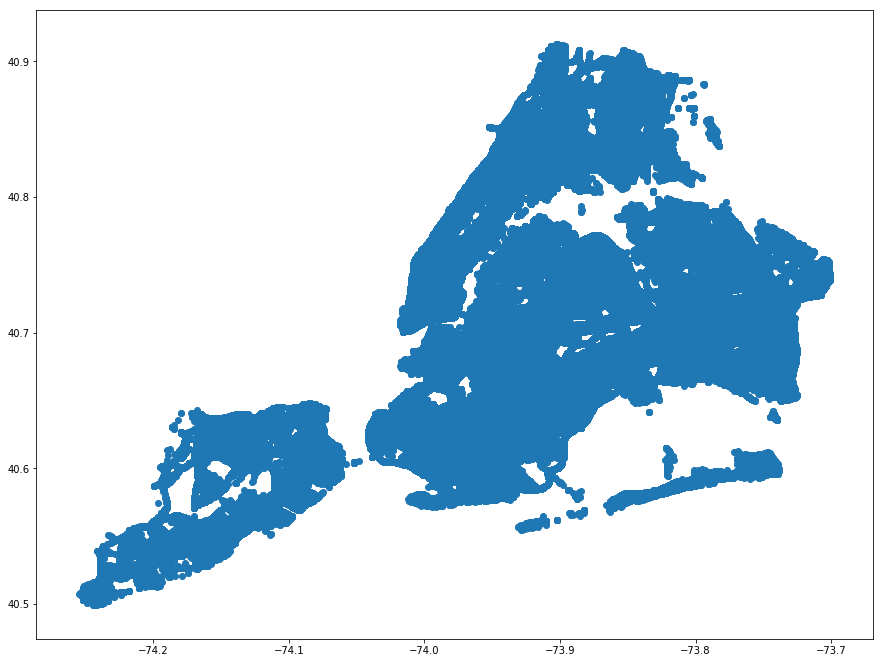

In [263]:
collision_gdf.plot(figsize=(15, 15));

In [264]:
collision_gdf.crs = {'init' :'epsg:4326'}

In [265]:
collision_gdf = collision_gdf.to_crs({'init': 'epsg:2263'})

In [266]:
collision_gdf.crs

{'init': 'epsg:2263'}

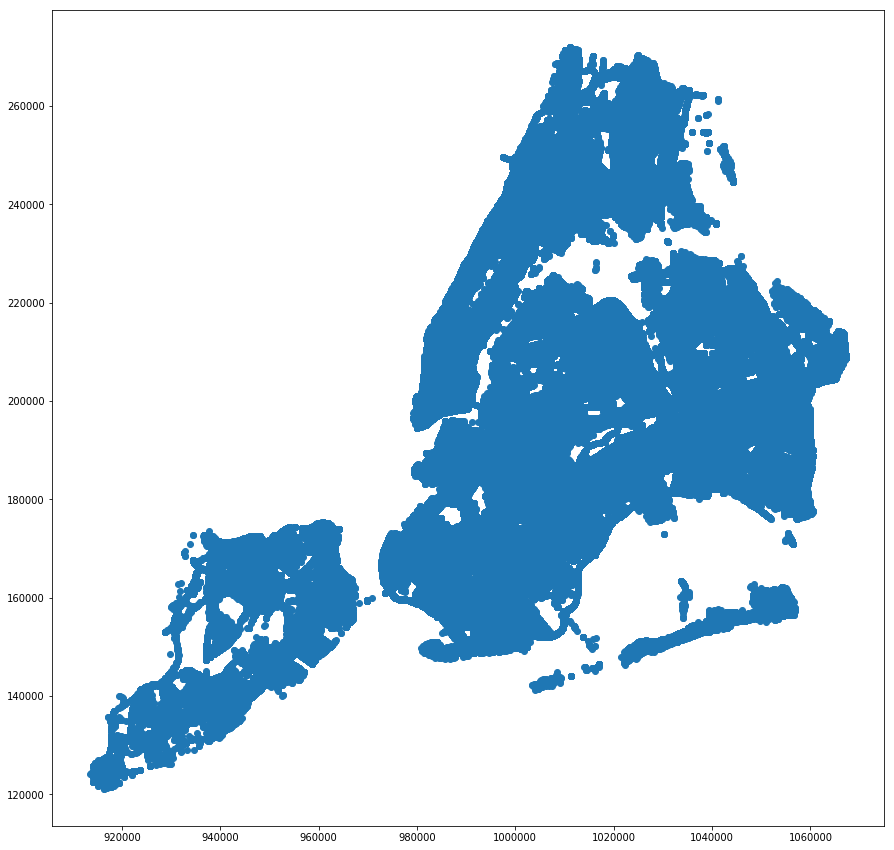

In [267]:
collision_gdf.plot(figsize=(15, 15));

In [274]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\DOT_traffic_signals_Oct_2018\signal_controllers_clean.dta"
sig_inters_df2 = pd.read_stata(fp)
sig_inters_df2.head(3)

intersection_id                 y                 x  \
0              1.0  199793.609300002        986336.149   
1              2.0  202206.161899999        982769.331   
2              3.0       201790.0942  982805.618399993   

                 st1_name          st2_name       st3_name st4_name  dup  
0            ALLEN STREET      CANAL STREET                            0  
1  AVENUE OF THE AMERICAS     LAIGHT STREET   CANAL STREET             0  
2  AVENUE OF THE AMERICAS  LISPENARD STREET  WEST BROADWAY             0

In [275]:
# Convert coordinates into float
sig_inters_df2['y'] = sig_inters_df2['y'].astype(float)
sig_inters_df2['x'] = sig_inters_df2['x'].astype(float)
# Put the latitude and longtitude 
sig_inters_df2['Coordinates'] = list(zip(sig_inters_df2.x, sig_inters_df2.y))
sig_inters_df2['Coordinates'] = sig_inters_df2['Coordinates'].apply(Point)
sig_inters_gdf2 = gpd.GeoDataFrame(sig_inters_df2, geometry='Coordinates')

In [277]:
sig_inters_gdf2.crs

In [279]:
sig_inters_gdf2.crs = {'init' :'epsg:2263'}
sig_inters_gdf2.crs

{'init': 'epsg:2263'}

In [280]:
collision_gdf[['distance_to_sigInt','nearest_sigInt']] = ckdnearest(collision_gdf, sig_inters_gdf2,'intersection_id')

In [281]:
collision_gdf.head(3)

uniquekey    year       date                time  latenight borough  \
0  3427749.0  2016.0 2016-04-24 1960-01-01 18:02:00        0.0           
1  3474445.0  2016.0 2016-07-05 1960-01-01 01:30:00        1.0           
2  3467416.0  2016.0 2016-06-22 1960-01-01 12:15:00        0.0           

  zipcode   latitude  longitude  mi_latlong  ...  vehicletypecode3  \
0          40.744896 -73.770203         0.0  ...                     
1          40.650494 -74.011772         0.0  ...                     
2          40.705044 -73.959030         0.0  ...                     

   vehicletypecode4 vehicletypecode5 bicyclerelated taxirelated publicrelated  \
0                                               0.0         0.0           0.0   
1                                               0.0         0.0           0.0   
2                                               0.0         0.0           0.0   

       dup                                  Coordinates  distance_to_sigInt  \
0  24989.0  POINT (1047925.420187834 210745.8332306232)                 749   
1  24989.0  POINT (980983.3829843847 176268.9676320423)                  30   
2  24989.0  POINT (995609.2936718578 196145.5996373807)                 111   

   nearest_sigInt  
0         11247.0  
1          5677.0  
2          7617.0  

[3 rows x 41 columns]

In [282]:
str_cols = list(collision_gdf.select_dtypes(include=['object']).columns)
for col in str_cols:
    collision_gdf[col] = collision_gdf[col].astype(str)

In [ ]:
fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\collision_signal_intersection.dta"

In [ ]:
#collision_gdf.to_stata(fp)

### 5. Calculate collision outcomes 
- stata


In [286]:
use "..\working_data\collision_signal_intersection.dta",clear

In [287]:
describe


Contains data from ..\working_data\collision_signal_intersection.dta
  obs:     1,147,839                          
 vars:            42                          15 Nov 2018 16:01
 size:   896,462,259                          
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
index           long    %12.0g                
uniquekey       double  %10.0g                
year            float   %9.0g                 
date            str10   %10s                  
time            str19   %19s                  
latenight       float   %9.0g                 
borough         str13   %13s      

In [288]:
gen intersection_id = nearest_sigInt

In [289]:
codebook intersection_id


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
intersection_id                                                                                                                                                      (unlabeled)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  numeric (float)

                 range:  [1,13214]                    units:  1
         unique values:  13,116                   missing .:  0/1,147,839

                  mean:    6513.4
              std. dev:   3979.88

           percentiles:        10%       25%       50%       75%       90%
                               981      3009      6437     10260     11828


In [290]:
// Determine if collisions that are close to an intersection
sum distance_to_sigInt, detail


                     distance_to_sigInt
-------------------------------------------------------------
      Percentiles      Smallest
 1%            2              0
 5%            2              0
10%            2              0       Obs           1,147,839
25%            3              0       Sum of Wgt.   1,147,839

50%           10                      Mean           208.3536
                        Largest       Std. Dev.      375.8735
75%          279           7498
90%          615           7500       Variance       141280.9
95%          853           7500       Skewness       4.267881
99%         1632           7685       Kurtosis       35.85233


In [291]:
sum distance_to_sigInt if distance_to_sigInt < r(p75), detail


                     distance_to_sigInt
-------------------------------------------------------------
      Percentiles      Smallest
 1%            1              0
 5%            2              0
10%            2              0       Obs             859,866
25%            3              0       Sum of Wgt.     859,866

50%            3                      Mean           51.85574
                        Largest       Std. Dev.      86.39933
75%           65            278
90%          227            278       Variance       7464.844
95%          259            278       Skewness       1.550851
99%          273            278       Kurtosis       3.837138


In [295]:
sum distance_to_sigInt if distance_to_sigInt < r(p75), detail


                     distance_to_sigInt
-------------------------------------------------------------
      Percentiles      Smallest
 1%            2              0
 5%            2              0
10%            2              0       Obs           1,147,839
25%            3              0       Sum of Wgt.   1,147,839

50%           10                      Mean           208.3536
                        Largest       Std. Dev.      375.8735
75%          279           7498
90%          615           7500       Variance       141280.9
95%          853           7500       Skewness       4.267881
99%         1632           7685       Kurtosis       35.85233


In [298]:
gen intersection = (distance_to_sigInt < 10)

In [299]:
tab intersection


intersectio |
          n |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    576,297       50.21       50.21
          1 |    571,542       49.79      100.00
------------+-----------------------------------
      Total |  1,147,839      100.00


In [300]:
codebook date


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
date                                                                                                                                                                 (unlabeled)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  string (str10)

         unique values:  2,277                    missing "":  0/1,147,839

              examples:  "2013-11-04"
                         "2015-03-06"
                         "2016-06-01"
                         "2017-09-03"


In [301]:
gen date2 = date(date, "YMD"),after(date)
format date2 %td
drop date
rename date2 date

In [302]:
%head

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  1. | index  | unique~y  | year  |       date  |                 time  |  lateni~t  |  borough  |  zipcode  |  latitude  |  longitude  |  mi_lat~g  |  imput_~g  |  mi_lat~2  |
     |     0  |  3427749  | 2016  |  24apr2016  |  1960-01-01 18:02:00  |         0  |           |           |   40.7449  |   -73.7702  |         0  |         0  |         0  |
     |-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------|
     |                  location | onstre~e | crosss~e |                            offstreetname | pers~red | pers~led | pede~red | pede~led | cycl~red | cycl~led | moto~red |
     | (40.7448949, -73.7702044) |          |          |                                          |        2 |        0 |        0 |        0 |        0 |        0 |        2 |
     |-------------------------------------------------------------------------------------------------------+--------------------------------+--------------------------------|
     | moto~led  |     contributingfactorvehicle1  | contributingf~2  | contribut~3  | contri~4  | contri~5  |              vehicletypecode1  |              vehicletypecode2  |
     |        0  |                Fatigued/Drowsy  | Fatigued/Drowsy  |              |           |           |             PASSENGER VEHICLE  |             PASSENGER VEHICLE  |
     |-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
     | vehicl~3 | vehicl~4 | vehicl~5 | bicycl~d | taxire~d | public~d |   dup  |                                 Coordinates  | distan~t  | neares~t  | inters~d  | inters~n  |
     |          |          |          |        0 |        0 |        0 | 24989  | POINT (1047925.420187834 210745.8332306232)  |      749  |    11247  |    11247  |        0  |
     +-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

     +-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
  2. | index  | unique~y  | year  |       date  |                 time  |  lateni~t  |  borough  |  zipcode  |  latitude  |  longitude  |  mi_lat~g  |  imput_~g  |  mi_lat~2  |
     |     1  |  3474445  | 2016  |  05jul2016  |  1960-01-01 01:30:00  |         1  |           |           |  40.65049  |  -74.01177  |         0  |         0  |         0  |
     |-------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------|
     |                  location | onstre~e | crosss~e |                            offstreetname | pers~red | pers~led | pede~red | pede~led | cycl~red | cycl~led | moto~red |
     | (40.6504919, -74.0117738) |          |          |                                          |        0 |        0 |        0 |        0 |        0 |        0 |        0 |
     |-------------------------------------------------------------------------------------------------------+--------------------------------+--------------------------------|
     | moto~led  |     contributingfactorvehicle1  | contributingf~2  | contribut~3  | contri~4  | contri~5  |              vehicletypecode1  |              vehicletypecode2  |
     |        0  |                    Unspecified  |     Unspecified  |              |           |           |             PASSENGER VEHICLE  |             PASSENGER VEHICLE  |
     |--------------------------------------------------------------------------------------------------------

In [303]:
gen month = month(date)
gen quarter = quarter(date)
gen collision_count = 1

In [304]:
gen latenight_collision_count = latenight*collision_count
gen latenight_personsinjured = latenight*personsinjured
gen latenight_personskilled = latenight*personskilled
gen latenight_pedestriansinjured = latenight*pedestriansinjured
gen latenight_pedestrianskilled = latenight*pedestrianskilled
gen latenight_cyclistinjured = latenight*cyclistinjured
gen latenight_cyclistkilled = latenight*cyclistkilled
gen latenight_motoristinjured = latenight*motoristinjured
gen latenight_motoristkilled = latenight*motoristkilled

gen day = (latenight == 0)

gen day_collision_count = day*collision_count
gen day_personsinjured = day*personsinjured
gen day_personskilled = day*personskilled
gen day_pedestriansinjured = day*pedestriansinjured
gen day_pedestrianskilled = day*pedestrianskilled
gen day_cyclistinjured = day*cyclistinjured
gen day_cyclistkilled = day*cyclistkilled
gen day_motoristinjured = day*motoristinjured
gen day_motoristkilled = day*motoristkilled



(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)



(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)

(1 missing value generated)


In [305]:
global counts collision_count latenight_collision_count day_collision_count
global all_outcome personsinjured personskilled pedestriansinjured pedestrianskilled cyclistinjured cyclistkilled motoristinjured motoristkilled 
global late_outcome latenight_personsinjured latenight_personskilled latenight_pedestriansinjured latenight_pedestrianskilled latenight_cyclistinjured latenight_cyclistkilled latenight_motoristinjured latenight_motoristkilled
global day_outcome day_personsinjured day_personskilled day_pedestriansinjured day_pedestrianskilled day_cyclistinjured day_cyclistkilled day_motoristinjured day_motoristkilled

In [306]:
preserve
collapse ///
(sum) "$counts $all_outcome $late_outcome $day_outcome" ///
 , by(intersection_id month year )

//save "..\working_data\collision_monthly.dta",replace
restore

In [ ]:
preserve
collapse ///
(sum) "$counts $all_outcome $late_outcome $day_outcome" ///
 , by(intersection_id quarter year)

//save "..\working_data\collision_quarterly.dta",replace
restore

### 6. Set up Quarterly Panel data
- stata

In [307]:
clear

In [308]:
cd

C:\Users\jerem\Box Sync\Policy Evaluation\dofiles


In [309]:
// There are 13213 signal intersections
global intersect = 13213+1
global periods_per_year = 4
global obs = $periods_per_year*7*($intersect)

display $obs
set obs $obs





369992

number of observations (_N) was 0, now 369,992


In [310]:
egen intersection_id = seq(), from(1) to($intersect)
sort intersection_id

In [311]:
egen quarter = seq(), from(1) to (4) by(intersection_id)
egen year = seq(), from(2012) to (2018) block(4) 

In [312]:
gen quarterly = yq(year,quarter)
format quarterly %tq

In [313]:
//These are outside of the range of our data
drop if quarter <= 2 & year == 2012
drop if quarter >= 4 & year == 2018


(26,428 observations deleted)

(13,214 observations deleted)


#### 6.a. Merge in Intersection Data

In [314]:
// Intersection level data
mmerge intersection_id using "..\working_data\signal_intersection.dta", ///
type(n:1) ///
unmatched(using) ///
umatch(intersection_id)



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | using
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 330350
                vars |      4
          match vars | intersection_id  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\signal_intersection.dta
                 obs |  13213
                vars |     38
          match vars | intersection_id  (key)
---------------------+---------------------------------------------------------
variable intersection_id does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 330325
                vars |     43  (including _merge)
         ------------+----

In [315]:
describe


Contains data
  obs:       330,325                          
 vars:            42                          
 size:   153,270,800                          
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
intersection_id int     %8.0g                 
quarter         byte    %8.0g                 
year            int     %8.0g                 
quarterly       int     %tq                   
index           int     %12.0g                
y               double  %10.0g                
x               double  %10.0g                
st1_name        str31   %31s                  
st2_name    

#### 6.b. Create borough dummies

In [316]:
tab bname,m


        bname |      Freq.     Percent        Cum.
--------------+-----------------------------------
        Bronx |     42,600       12.90       12.90
     Brooklyn |    117,400       35.54       48.44
    Manhattan |     71,775       21.73       70.17
       Queens |     82,800       25.07       95.23
Staten Island |     15,650        4.74       99.97
          nan |        100        0.03      100.00
--------------+-----------------------------------
        Total |    330,325      100.00


In [317]:
gen bronx = (bname == "Bronx")
gen brooklyn = (bname == "Brooklyn")
gen manhattan = (bname == "Manhattan")
gen queens = (bname == "Queens")
gen statenisland = (bname == "Staten Island")

#### 6.c. Nearest Bike Route

In [320]:
destring nearest_bikeroute,replace

nearest_bikeroute already numeric; no replace


In [321]:
mmerge nearest_bikeroute using "..\working_data\bike_routes_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(objectid_1) ///
ukeep(date_instd tf_facilit)



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 330325
                vars |     46
          match vars | nearest_bikeroute  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\bike_routes_2263.dta
                 obs |  14980
                vars |      3  (selection via udrop/ukeep)
          match vars | objectid_1  (key)
---------------------+---------------------------------------------------------
variable nearest_bikeroute does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 330325
                vars |     50  (including _merge)


In [322]:
gen bike_route_install_dt = date(date_instd, "YMD"), after(date_instd)
format bike_route_install_dt %td

In [323]:
sum bike_route_install_dt, format


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
bike_route~t |    330,325   24nov2002    7771.114  01jan1900  23dec2016


In [324]:
gen bike_route_install_mt = mofd(bike_route_install_dt)
format bike_route_install_mt %tm

In [325]:
sum bike_route_install_mt, format


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
bike_rout~mt |    330,325   2002m11    255.2326   1900m1  2016m12


In [326]:
gen bike_route_install_qt = qofd(bike_route_install_dt)
format bike_route_install_qt %tq

In [327]:
sum bike_route_install_qt, format


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
bike_rout~qt |    330,325   2002q4    85.00089  1900q1  2016q4


##### Determine if collision occured on bike route

In [328]:
sum distance_to_bikeroute, detail


                    distance_to_bikeroute
-------------------------------------------------------------
      Percentiles      Smallest
 1%            0              0
 5%            0              0
10%            1              0       Obs             330,325
25%            3              0       Sum of Wgt.     330,325

50%          537                      Mean           1023.112
                        Largest       Std. Dev.      1365.944
75%         1416           8907
90%         2871           8907       Variance        1865802
95%         4039           8907       Skewness        2.00231
99%         6101           8907       Kurtosis       7.320251


In [329]:
sum distance_to_bikeroute if distance_to_bikeroute < r(p50) , detail


                    distance_to_bikeroute
-------------------------------------------------------------
      Percentiles      Smallest
 1%            0              0
 5%            0              0
10%            0              0       Obs             165,025
25%            1              0       Sum of Wgt.     165,025

50%            3                      Mean           122.9515
                        Largest       Std. Dev.      176.5845
75%          262            536
90%          447            536       Variance       31182.09
95%          507            536       Skewness       1.105402
99%          530            536       Kurtosis        2.69221


In [330]:
// Time invariant bike route indicator
gen bike_route_ever = distance_to_bikeroute <= 3
label variable bike_route_ever "Indicates that bike route passes through this intersection (<3 ft)"

In [331]:
tab bike_route_ever


  Indicates |
  that bike |
      route |
     passes |
    through |
       this |
intersectio |
  n (<3 ft) |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    245,200       74.23       74.23
          1 |     85,125       25.77      100.00
------------+-----------------------------------
      Total |    330,325      100.00


In [333]:
// Time-variant bike route indicator
gen bike_route_tv = 0 
replace bike_route_tv = 1 if quarterly >= bike_route_install_qt & bike_route_ever == 1
label variable bike_route_tv "Indicates that bike route passes through this intersection timevarient(<3 ft)"




(74,140 real changes made)



In [334]:
tab bike_route_tv


  Indicates |
  that bike |
      route |
     passes |
    through |
       this |
intersectio |
          n |
timevarient |
    (<3 ft) |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    256,185       77.56       77.56
          1 |     74,140       22.44      100.00
------------+-----------------------------------
      Total |    330,325      100.00


In [347]:
tab bike_route_tv year


 Indicates |
 that bike |
     route |
    passes |
   through |
      this |
intersecti |
        on |
timevarien |                                     year
  t(<3 ft) |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    21,681     42,808     41,981     41,054     40,005     39,232     29,424 |   256,185 
         1 |     4,745     10,044     10,871     11,798     12,847     13,620     10,215 |    74,140 
-----------+-----------------------------------------------------------------------------+----------
     Total |    26,426     52,852     52,852     52,852     52,852     52,852     39,639 |   330,325 


#### 6.d. Left Turn Calming Intervention

In [335]:
rename treatment_ left_turn_treatment

In [336]:
gen left_turn_install_dt = date(completion, "YMD"), after(completion)
format left_turn_install_dt %td
gen int left_turn_install_mt = mofd(left_turn_install_dt), after(left_turn_install_dt)
format left_turn_install_mt %tm
gen int left_turn_install_qt = qofd(left_turn_install_dt), after(left_turn_install_dt)
format left_turn_install_qt %tq

##### Matching intersection to closest left turn calming intervention

In [337]:
egen double left_turn_min = min(distance_to_LTC), by(nearest_LTC)

In [338]:
gen flag_left_turn_ever = .
replace flag_left_turn_ever = 1 if left_turn_min == distance_to_LTC
replace flag_left_turn_ever = 0 if mi(flag_left_turn_ever)


(330,325 missing values generated)

(5,800 real changes made)

(324,525 real changes made)


In [339]:
gen flag_left_turn = flag_left_turn_ever
replace flag_left_turn = 0 if flag_left_turn == 1 & quarterly < left_turn_install_qt



(4,359 real changes made)


In [345]:
tab flag_left_turn year


flag_left_ |                                     year
      turn |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    26,426     52,852     52,852     52,852     52,676     52,266     38,960 |   328,884 
         1 |         0          0          0          0        176        586        679 |     1,441 
-----------+-----------------------------------------------------------------------------+----------
     Total |    26,426     52,852     52,852     52,852     52,852     52,852     39,639 |   330,325 


#### 6.e. Street Improvement Project intervention

In [340]:
rename SIPProjTyp street_improv_treatment

In [341]:
gen street_improv_install_dt = date(DateComplt, "YMD"), after(DateComplt)
format street_improv_install_dt %td
gen int street_improv_install_mt = mofd(street_improv_install_dt), after(street_improv_install_dt)
format street_improv_install_mt %tm
gen int street_improv_install_qt = qofd(street_improv_install_dt), after(street_improv_install_dt)
format street_improv_install_qt %tq

##### Matching intersection to closest street improvement project

In [342]:
egen double street_improv_min = min(distance_to_StImpro), by(nearest_StImpro)

In [343]:
gen flag_street_improv_ever = .
replace flag_street_improv_ever = 1 if street_improv_min == distance_to_StImpro
replace flag_street_improv_ever = 0 if mi(flag_street_improv_ever)


(330,325 missing values generated)

(9,125 real changes made)

(321,200 real changes made)


In [344]:
gen flag_street_improv = flag_street_improv_ever
replace flag_street_improv = 0 if flag_street_improv == 1 & quarterly < street_improv_install_qt



(4,592 real changes made)


In [346]:
tab flag_street_improv year


flag_stree |                                     year
  t_improv |      2012       2013       2014       2015       2016       2017       2018 |     Total
-----------+-----------------------------------------------------------------------------+----------
         0 |    26,297     52,556     52,449     52,234     51,957     51,704     38,595 |   325,792 
         1 |       129        296        403        618        895      1,148      1,044 |     4,533 
-----------+-----------------------------------------------------------------------------+----------
     Total |    26,426     52,852     52,852     52,852     52,852     52,852     39,639 |   330,325 


#### 6.f. Leading Pedestrian Interval Signal

In [348]:
gen LPIS_install_dt = date(date_insta, "YMD")
format LPIS_install_dt %td
gen int LPIS_install_mt = mofd(LPIS_install_dt), after(LPIS_install_dt)
format LPIS_install_mt %tm
gen int LPIS_install_qt = qofd(LPIS_install_dt), after(LPIS_install_mt)
format LPIS_install_qt %tq 
gen LPIS_install_yr = year(LPIS_install_dt), after(LPIS_install_qt)

##### Matching intersection to closest leading pedestrian interval signal

In [349]:
egen double LPIS_min = min(distance_to_LPIS), by(nearest_LPIS)

In [350]:
gen flag_LPIS_ever = .
replace flag_LPIS_ever = 1 if LPIS_min == distance_to_LPIS
replace flag_LPIS_ever = 0 if mi(flag_LPIS_ever)


(330,325 missing values generated)

(72,875 real changes made)

(257,450 real changes made)


In [351]:
gen flag_LPIS = flag_LPIS_ever

In [356]:
// Replace with indicator with 0 if quarter was before LPIS installation
replace flag_LPIS = 0 if flag_LPIS == 1 & quarterly < LPIS_install_qt

(47,593 real changes made)


In [368]:
label variable flag_LPIS "Indicates the intersection at the time they became an LPIS intervention"
label variable flag_LPIS_ever "Indicates the intersection if they ever received LPIS intervention"

##### Problem: Certain LPIs intersections had been install before collision data

In [357]:
sum quarterly, detail format


                          quarterly
-------------------------------------------------------------
      Percentiles      Smallest
 1%    2012q3      2012q3
 5%    2012q4      2012q3
10%    2013q1      2012q3       Obs             330,325
25%    2014q1      2012q3       Sum of Wgt.     330,325

50%    2015q3                      Mean          2015q3
                        Largest       Std. Dev.      7.211113
75%    2017q1      2018q3
90%    2018q1      2018q3       Variance       52.00016
95%    2018q2      2018q3       Skewness              0
99%    2018q3      2018q3       Kurtosis       1.796154


In [358]:
sum LPIS_install_qt, detail format


                       LPIS_install_qt
-------------------------------------------------------------
      Percentiles      Smallest
 1%    1899q4      1899q4
 5%    2004q1      1899q4
10%    2013q2      1899q4       Obs             330,325
25%    2015q4      1899q4       Sum of Wgt.     330,325

50%    2016q3                      Mean          2014q2
                        Largest       Std. Dev.       51.7974
75%    2017q3      2018q3
90%    2018q2      2018q3       Variance       2682.971
95%    2018q3      2018q3       Skewness      -7.818992
99%    2018q3      2018q3       Kurtosis       68.19259


We will remove intersections that cannot be analyzed because LPIs was implemented before 01jul2012

In [359]:
tab flag_LPIS if LPIS_install_qt < tq(2013q1)


  flag_LPIS |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |     26,477       82.42       82.42
          1 |      5,648       17.58      100.00
------------+-----------------------------------
      Total |     32,125      100.00


In [360]:
tab intersection_id if LPIS_install_qt < tq(2013q1) & flag_LPIS_ever == 1


intersectio |
       n_id |      Freq.     Percent        Cum.
------------+-----------------------------------
          7 |         25        0.44        0.44
          8 |         25        0.44        0.88
         17 |         25        0.44        1.33
         57 |         25        0.44        1.77
         58 |         25        0.44        2.21
         61 |         25        0.44        2.65
         83 |         25        0.44        3.10
        109 |         25        0.44        3.54
        149 |         25        0.44        3.98
        151 |         25        0.44        4.42
        161 |         25        0.44        4.87
        230 |         25        0.44        5.31
        231 |         25        0.44        5.75
        238 |         25        0.44        6.19
        239 |         25        0.44        6.64
        243 |         25        0.44        7.08
        255 |         25        0.44        7.52
        256 |         25        0.44        7.96
     

       5805 |         25        0.44       73.45
       5827 |         25        0.44       73.89
       6030 |         25        0.44       74.34
       6152 |         25        0.44       74.78
       6153 |         25        0.44       75.22
       6179 |         25        0.44       75.66
       6255 |         25        0.44       76.11
       6318 |         25        0.44       76.55
       6428 |         25        0.44       76.99
       6751 |         25        0.44       77.43
       6807 |         25        0.44       77.88
       6822 |         25        0.44       78.32
       6868 |         25        0.44       78.76
       7316 |         25        0.44       79.20
       7506 |         25        0.44       79.65
       9193 |         25        0.44       80.09
       9299 |         25        0.44       80.53
       9516 |         25        0.44       80.97
       9821 |         25        0.44       81.42
       9830 |         25        0.44       81.86
       9831 |       

In [361]:
drop if LPIS_install_qt < tq(2013q1) & flag_LPIS_ever == 1

(5,650 observations deleted)


#### 6.g. Safe Streets for Seniors

In [369]:
codebook Name


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Name                                                                                                                                                                 (unlabeled)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  string (str26)

         unique values:  42                       missing "":  0/324,675

              examples:  "nan"
                         "nan"
                         "nan"
                         "nan"



In [370]:
tab Name


                      Name |      Freq.     Percent        Cum.
---------------------------+-----------------------------------
                   Astoria |        775        0.24        0.24
                Bath Beach |        975        0.30        0.54
                 Bay Ridge |      1,700        0.52        1.06
        Bedford Stuyvesant |      4,600        1.42        2.48
               Bensonhurst |      2,475        0.76        3.24
              Borough Park |      5,000        1.54        4.78
            Brighton Beach |        225        0.07        4.85
               Brownsville |      5,100        1.57        6.42
        Chelsea/9th Avenue |      1,900        0.59        7.01
                 Chinatown |        475        0.15        7.15
           Corona Elmhurst |      7,125        2.19        9.35
            East Concourse |        450        0.14        9.49
             East Flatbush |        600        0.18        9.67
               East Harlem |      2,625

In [371]:
gen flag_seniors = (strpos(Name, "nan") == 0)

In [373]:
tab flag_seniors


flag_senior |
          s |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    260,275       80.16       80.16
          1 |     64,400       19.84      100.00
------------+-----------------------------------
      Total |    324,675      100.00


In [374]:
tab flag_seniors flag_LPIS


           |     Indicates the
           |  intersection at the
           |  time they became an
flag_senio |   LPIS intervention
        rs |         0          1 |     Total
-----------+----------------------+----------
         0 |   246,705     13,570 |   260,275 
         1 |    58,336      6,064 |    64,400 
-----------+----------------------+----------
     Total |   305,041     19,634 |   324,675 


#### 6.h. Priority Intersection

In [377]:
sum distance_to_p*, detail


                 distance_to_priorityinters
-------------------------------------------------------------
      Percentiles      Smallest
 1%            3              0
 5%          372              0
10%          640              0       Obs             324,675
25%         1110              0       Sum of Wgt.     324,675

50%         1991                      Mean           2603.942
                        Largest       Std. Dev.      2534.222
75%         3221          28481
90%         4978          28481       Variance        6422279
95%         6561          28481       Skewness        3.67198
99%        13842          28481       Kurtosis       23.89315


In [376]:
gen flag_priorityinters = (distance_to_priorityinters < 10)

In [379]:
tab flag_priorityinters


flag_priori |
   tyinters |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    319,200       98.31       98.31
          1 |      5,475        1.69      100.00
------------+-----------------------------------
      Total |    324,675      100.00


In [378]:
tab flag_priorityinters flag_LPIS


           |     Indicates the
           |  intersection at the
           |  time they became an
flag_prior |   LPIS intervention
 ityinters |         0          1 |     Total
-----------+----------------------+----------
         0 |   300,649     18,551 |   319,200 
         1 |     4,392      1,083 |     5,475 
-----------+----------------------+----------
     Total |   305,041     19,634 |   324,675 


#### 6.i. School intersection/crossing

In [380]:
sum distance_to_Sch,detail


                       distance_to_Sch
-------------------------------------------------------------
      Percentiles      Smallest
 1%          125             17
 5%          197             17
10%          246             17       Obs             324,675
25%          425             17       Sum of Wgt.     324,675

50%          692                      Mean           822.7985
                        Largest       Std. Dev.      612.1056
75%         1055          10685
90%         1511          10685       Variance       374673.3
95%         1872          10685       Skewness       3.568631
99%         2871          10685       Kurtosis        35.5307


In [381]:
gen flag_school = (distance_to_Sch < 200)

In [382]:
tab flag_school


flag_school |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |    307,775       94.79       94.79
          1 |     16,900        5.21      100.00
------------+-----------------------------------
      Total |    324,675      100.00


In [383]:
tab flag_school flag_LPIS 


           |     Indicates the
           |  intersection at the
           |  time they became an
flag_schoo |   LPIS intervention
         l |         0          1 |     Total
-----------+----------------------+----------
         0 |   289,690     18,085 |   307,775 
         1 |    15,351      1,549 |    16,900 
-----------+----------------------+----------
     Total |   305,041     19,634 |   324,675 


#### 6.j. Decay effect

In [362]:
sort intersection_id quarterly

In [363]:
bysort intersection_id: gen flag_LPIS_1yr = 1 if quarterly == (LPIS_install_qt+1)
bysort intersection_id: replace flag_LPIS_1yr = 1 if quarterly == (LPIS_install_qt+2)
bysort intersection_id: replace flag_LPIS_1yr = 1 if quarterly == (LPIS_install_qt+3)
bysort intersection_id: replace flag_LPIS_1yr = 1 if quarterly == (LPIS_install_qt+4)
replace flag_LPIS_1yr = 0 if missing(flag_LPIS_1yr)
replace flag_LPIS_1yr = 0 if flag_LPIS_ever == 0


(313,505 missing values generated)

(10,265 real changes made)

(9,357 real changes made)

(8,784 real changes made)

(285,099 real changes made)

(30,934 real changes made)


In [364]:
bysort intersection_id: gen flag_LPIS_2yr = 1 if quarterly == (LPIS_install_qt+5)
bysort intersection_id: replace flag_LPIS_2yr = 1 if quarterly == (LPIS_install_qt+6)
bysort intersection_id: replace flag_LPIS_2yr = 1 if quarterly == (LPIS_install_qt+7)
bysort intersection_id: replace flag_LPIS_2yr = 1 if quarterly == (LPIS_install_qt+8)
replace flag_LPIS_2yr = 0 if missing(flag_LPIS_2yr)
replace flag_LPIS_2yr = 0 if flag_LPIS_ever == 0


(316,621 missing values generated)

(7,091 real changes made)

(6,147 real changes made)

(5,611 real changes made)

(297,772 real changes made)

(21,441 real changes made)


In [365]:
bysort intersection_id: gen flag_LPIS_2yrup = 1 if quarterly == (LPIS_install_qt+5)
bysort intersection_id: replace flag_LPIS_2yrup = 1 if flag_LPIS_2yrup[_n-1] == 1
replace flag_LPIS_2yrup = 0 if missing(flag_LPIS_2yrup)
replace flag_LPIS_2yrup = 0 if flag_LPIS_ever == 0


(316,621 missing values generated)

(35,482 real changes made)

(281,139 real changes made)

(35,233 real changes made)


In [366]:
bysort intersection_id: gen flag_LPIS_3yrup = 1 if quarterly == (LPIS_install_qt+9)
bysort intersection_id: replace flag_LPIS_3yrup = 1 if flag_LPIS_3yrup[_n-1] == 1
replace flag_LPIS_3yrup = 0 if missing(flag_LPIS_3yrup)
replace flag_LPIS_3yrup = 0 if flag_LPIS_ever == 0


(320,275 missing values generated)

(14,683 real changes made)

(305,592 real changes made)

(16,242 real changes made)


#### 6.k. Panel is strongly balanced

In [367]:
duplicates report intersection_id


Duplicates in terms of intersection_id

--------------------------------------
   copies | observations       surplus
----------+---------------------------
       25 |       324675        311688
--------------------------------------


#### 6.l. Merge outcomes data

In [384]:
// Outcomes data
mmerge quarter year intersection_id using "..\working_data\collision_quarterly.dta", ///
type(1:1) ///
unmatched(master) 


-------------------------------------------------------------------------------
merge specs          |
       matching type | 1:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 324675
                vars |     79
          match vars | quarter year intersection_id  (key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\collision_quarterly.dta
                 obs | 195341
                vars |     30
          match vars | quarter year intersection_id  (key)
---------------------+---------------------------------------------------------
result          file | <data in memory not named>
                 obs | 324675
                vars |    108  (including _merge)
         ------------+---------------------------------------------------------
          

Reason that we did not match every obs from using is:  
1. That we droped intersections in the intersection level data merge process
2. Certain LPIS junctions have been installed before the collisions datasets begin

#### 6.m. Fill in missing information

In [385]:
// Fill in '0' for intersection quarter year that did not have collisions
replace personsinjured = 0 if _merge == 1
replace personskilled = 0 if _merge == 1
replace pedestriansinjured = 0 if _merge == 1
replace pedestrianskilled = 0 if _merge == 1
replace cyclistinjured = 0 if _merge == 1
replace cyclistkilled = 0 if _merge == 1
replace motoristinjured = 0 if _merge == 1
replace motoristkilled = 0 if _merge == 1
replace collision_count = 0 if mi(collision_count)

replace latenight_personsinjured = 0 if _merge == 1
replace latenight_personskilled = 0 if _merge == 1
replace latenight_pedestriansinjured = 0 if _merge == 1
replace latenight_pedestrianskilled = 0 if _merge == 1
replace latenight_cyclistinjured = 0 if _merge == 1
replace latenight_cyclistkilled = 0 if _merge == 1
replace latenight_motoristinjured = 0 if _merge == 1
replace latenight_motoristkilled = 0 if _merge == 1
replace latenight_collision_count = 0 if mi(latenight_collision_count)

replace day_personsinjured = 0 if _merge == 1
replace day_personskilled = 0 if _merge == 1
replace day_pedestriansinjured = 0 if _merge == 1
replace day_pedestrianskilled = 0 if _merge == 1
replace day_cyclistinjured = 0 if _merge == 1
replace day_cyclistkilled = 0 if _merge == 1
replace day_motoristinjured = 0 if _merge == 1
replace day_motoristkilled = 0 if _merge == 1
replace day_collision_count = 0 if mi(day_collision_count)


(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)

(133,939 real changes made)


In [387]:
gen flag_collision = collision_count > 0
gen latenight_flag_collision = latenight_collision_count > 0
gen day_flag_collision = day_collision_count > 0

Label outcomes variables

In [388]:
label variable personsinjured "No. of persons injured during that month"
label variable personskilled "No. of persons killed during that month"
label variable pedestriansinjured "No. of pedestrians injured during that month"
label variable pedestrianskilled "No. of pedestrians killed during that month"
label variable cyclistinjured "No. of cyclist injured during that month"
label variable cyclistkilled "No. of cyclist killed during that month"
label variable motoristinjured "No. of motorist injured during that month"
label variable motoristkilled "No. of motorist killed during that month"
label variable collision_count "No. of collisions occured during that month"
label variable flag_collision "At least one collision occurred that month"

label variable latenight_personsinjured "No. of persons injured during that month between 11pm - 5am"
label variable latenight_personskilled "No. of persons killed during that month between 11pm - 5am"
label variable latenight_pedestriansinjured "No. of pedestrians injured during that month between 11pm - 5am"
label variable latenight_pedestrianskilled "No. of pedestrians killed during that month between 11pm - 5am"
label variable latenight_cyclistinjured "No. of cyclist injured during that month between 11pm - 5am"
label variable latenight_cyclistkilled "No. of cyclist killed during that month between 11pm - 5am"
label variable latenight_motoristinjured "No. of motorist injured during that month between 11pm - 5am"
label variable latenight_motoristkilled "No. of motorist killed during that month between 11pm - 5am"
label variable latenight_collision_count "No. of collisions occured during that month between 11pm - 5am"
label variable latenight_flag_collision " At least one collision occurred that month between 11pm - 5am"

label variable day_personsinjured "No. of persons injured during that month between 5am - 11pm"
label variable day_personskilled "No. of persons killed during that month between 5am - 11pm"
label variable day_pedestriansinjured "No. of pedestrians injured during that month between 5am - 11pm"
label variable day_pedestrianskilled "No. of pedestrians killed during that month between 5am - 11pm"
label variable day_cyclistinjured "No. of cyclist injured during that month between 5am - 11pm"
label variable day_cyclistkilled "No. of cyclist killed during that month between 5am - 11pm"
label variable day_motoristinjured "No. of motorist injured during that month between 5am - 11pm"
label variable day_motoristkilled "No. of motorist killed during that month between 5am - 11pm"
label variable day_collision_count "No. of collisions occured during that month between 5am - 11pm"
label variable day_flag_collision " At least one collision occurred that month between 5am - 11pm"

In [ ]:
//save "..\working_data\analytical_file_panel_qt.dta",replace

### 7. Convert analytical panel data into shapefile 
- python

In [389]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\analytical_file_panel_qt.dta"

In [390]:
analytical_df = pd.read_stata(fp)

In [391]:
analytical_df.head(3)

intersection_id  quarter  year  quarterly  index            y            x  \
0                1        1  2013 2013-01-01      0  199793.6093  986336.1490   
1                2        1  2013 2013-01-01      1  202206.1619  982769.3310   
2                3        1  2013 2013-01-01      2  201790.0942  982805.6184   

                 st1_name          st2_name       st3_name  ...  \
0            ALLEN STREET      CANAL STREET                 ...   
1  AVENUE OF THE AMERICAS     LAIGHT STREET   CANAL STREET  ...   
2  AVENUE OF THE AMERICAS  LISPENARD STREET  WEST BROADWAY  ...   

  day_personskilled  day_pedestriansinjured day_pedestrianskilled  \
0                 0                       0                     0   
1                 0                       0                     0   
2                 0                       0                     0   

   day_cyclistinjured  day_cyclistkilled  day_motoristinjured  \
0                   0                  0                    0   
1                   0                  0                    0   
2                   0                  0                    0   

   day_motoristkilled  flag_collision  latenight_flag_collision  \
0                   0             1.0                       0.0   
1                   0             0.0                       0.0   
2                   0             0.0                       0.0   

   day_flag_collision  
0                 1.0  
1                 0.0  
2                 0.0  

[3 rows x 163 columns]

In [393]:
analytical_df.columns

Index(['intersection_id', 'quarter', 'year', 'quarterly', 'index', 'y', 'x',
       'st1_name', 'st2_name', 'st3_name',
       ...
       'day_personskilled', 'day_pedestriansinjured', 'day_pedestrianskilled',
       'day_cyclistinjured', 'day_cyclistkilled', 'day_motoristinjured',
       'day_motoristkilled', 'flag_collision', 'latenight_flag_collision',
       'day_flag_collision'],
      dtype='object', length=163)

In [394]:
# Put the latitude and longtitude 
analytical_df['geometry'] = list(zip(analytical_df.x, analytical_df.y))
analytical_df['geometry'] = analytical_df['geometry'].apply(Point)
analytical_gdf = gpd.GeoDataFrame(analytical_df, geometry='geometry')

In [395]:
analytical_gdf.crs = {'init' :'epsg:2263'}

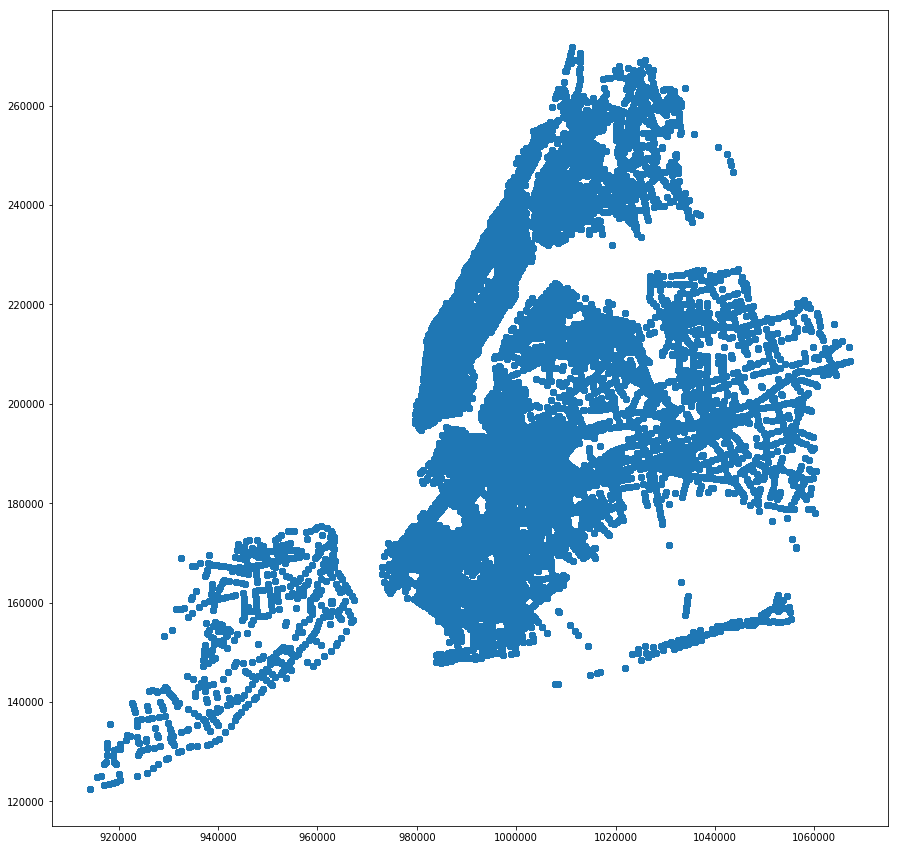

In [396]:
analytical_gdf.plot(figsize=(15, 15));

The shapefile is required to calculate contiguity matrix in Stata

In [397]:
 save_out = analytical_gdf[['collision_count','personsinjured','pedestriansinjured','cyclistinjured','motoristinjured',
                 'bronx','brooklyn','manhattan','queens','statenisland','distance_to_LPIS','distance_to_Street',
                 'distance_to_Sch','distance_to_LTC','distance_to_bikeroute','distance_to_truckroute',
                 'flag_left_turn_ever','flag_left_turn','flag_LPIS_ever','flag_LPIS','bike_route_tv',
                 'bike_route_ever', 'flag_seniors','flag_priorityinters','flag_school', 'flag_street_improv',
                 'quarter','year','intersection_id','y','x','geometry']]

In [398]:
fp =  r"C:\Users\jerem\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile.shp"

In [ ]:
#save_out.to_file(origin+fp)

### 8. Thiessen Polygons
- python

In [474]:
analytical_gdf.columns

Index(['intersection_id', 'quarter', 'year', 'quarterly', 'index', 'y', 'x',
       'st1_name', 'st2_name', 'st3_name',
       ...
       'day_pedestriansinjured', 'day_pedestrianskilled', 'day_cyclistinjured',
       'day_cyclistkilled', 'day_motoristinjured', 'day_motoristkilled',
       'flag_collision', 'latenight_flag_collision', 'day_flag_collision',
       'geometry'],
      dtype='object', length=164)

We want to extract only the cross section of the quarterly panel shapefile

In [423]:
analytical_gdf.head(3)

intersection_id  quarter  year  quarterly  index            y            x  \
0                1        1  2013 2013-01-01      0  199793.6093  986336.1490   
1                2        1  2013 2013-01-01      1  202206.1619  982769.3310   
2                3        1  2013 2013-01-01      2  201790.0942  982805.6184   

                 st1_name          st2_name       st3_name  ...  \
0            ALLEN STREET      CANAL STREET                 ...   
1  AVENUE OF THE AMERICAS     LAIGHT STREET   CANAL STREET  ...   
2  AVENUE OF THE AMERICAS  LISPENARD STREET  WEST BROADWAY  ...   

  day_pedestriansinjured  day_pedestrianskilled day_cyclistinjured  \
0                      0                      0                  0   
1                      0                      0                  0   
2                      0                      0                  0   

   day_cyclistkilled  day_motoristinjured  day_motoristkilled  flag_collision  \
0                  0                    0                   0             1.0   
1                  0                    0                   0             0.0   
2                  0                    0                   0             0.0   

   latenight_flag_collision  day_flag_collision  \
0                       0.0                 1.0   
1                       0.0                 0.0   
2                       0.0                 0.0   

                                      geometry  
0         POINT (986336.149 199793.6092999524)  
1  POINT (982769.3309999987 202206.1618999382)  
2  POINT (982805.6183999931 201790.0941999445)  

[3 rows x 164 columns]

In [428]:
# Extract cross section of quarter==3 & year == 2012
sub_analytical_gdf = gpd.GeoDataFrame(analytical_gdf.loc[(analytical_gdf['quarter'] == 3) & (analytical_gdf['year'] == 2012)])

In [432]:
sub_analytical_gdf['intersection_id'].count()

12987

In [434]:
sub_analytical_gdf.crs = {'init': 'epsg:2263'}

In [436]:
points = list(zip(sub_analytical_gdf.x,sub_analytical_gdf.y))

Instead of extracting a cross section, we can also collapse the data to the unique intersections level

In [479]:
collapsed_analytical_gdf = gpd.GeoDataFrame(analytical_gdf.groupby('intersection_id').agg({
    'collision_count': sum, # find the sum of collision_count in each intersection
    'personsinjured': sum, # find the sum of personsinjured in each intersection
    'pedestriansinjured': sum, # find the sum of pedestriansinjured in each intersection
    'cyclistinjured': sum , # find the sum of cyclistinjured in each intersection
    'motoristinjured': sum , # find the sum of motoristinjured in each intersection
    'flag_LPIS_ever': "first" ,
    'x': "first",
    'y': "first",
    'geometry': "first"})).reset_index()    # find the first geometry

In [495]:
collapsed_analytical_gdf.columns

Index(['intersection_id', 'collision_count', 'personsinjured',
       'pedestriansinjured', 'cyclistinjured', 'motoristinjured',
       'flag_LPIS_ever', 'x', 'y', 'geometry'],
      dtype='object')

In [480]:
collapsed_analytical_gdf['intersection_id'].count()

12987

In [481]:
collapsed_analytical_gdf.crs = {'init': 'epsg:2263'}

In [482]:
points = list(zip(collapsed_analytical_gdf.x,collapsed_analytical_gdf.y))

#### 8.a. Voronoi

Creates dataframe regions and vertices

source: https://github.com/pysal/libpysal/blob/master/notebooks/voronoi.ipynb

In [483]:
regions, vertices = voronoi_frames(points)

In [494]:
regions.columns

Index(['geometry'], dtype='object')

In [484]:
regions.crs = {'init': 'epsg:2263'}
vertices.crs = {'init': 'epsg:2263'}

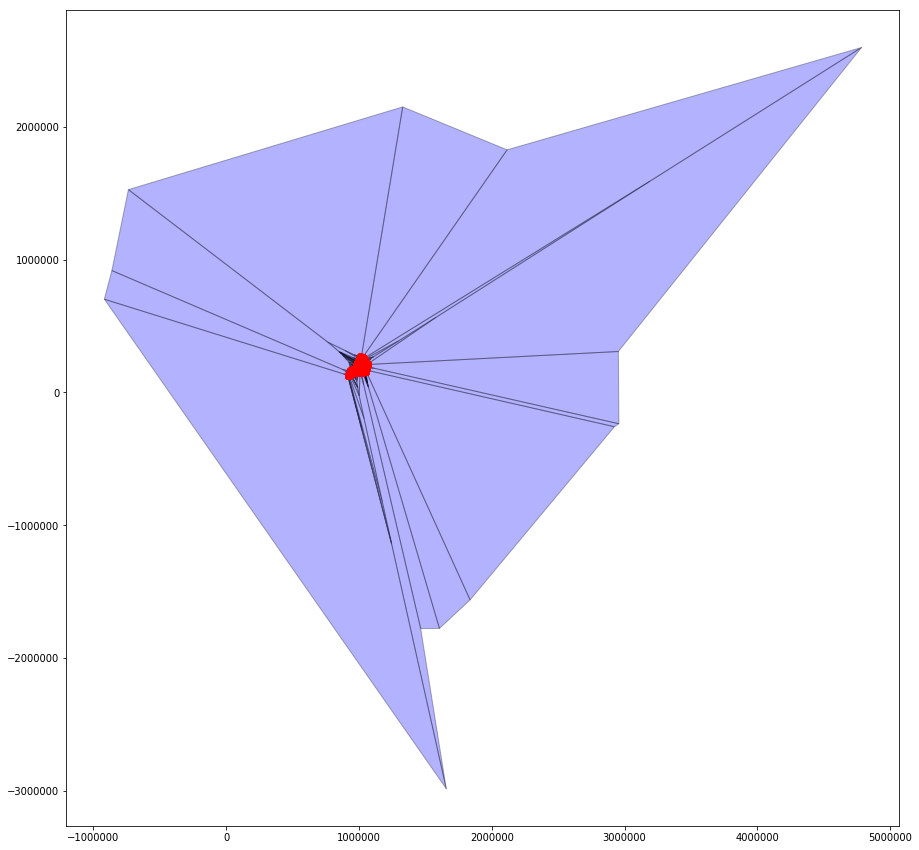

In [485]:
fig, ax = plt.subplots(figsize=(15, 15))
regions.plot(ax=ax, color='blue',edgecolor='black', alpha=0.3)
vertices.plot(ax=ax, color='red');

Problem here is that the voronoi polygons extends far out from NYC's boundaries. Therefore, we will use `geopandas`'s `overlay` to "cut" the borough shape out.

In [459]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\input_data\nyc_boroughs_2263\nyc_boroughs_2263.shp"

In [460]:
borough_gdf = gpd.read_file(fp)

In [461]:
borough_gdf.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [462]:
borough_gdf = borough_gdf.to_crs({'init': 'epsg:2263'})

In [463]:
borough_gdf.count()

bcode       5
bname       5
name        5
namelsad    5
geometry    5
dtype: int64

There are multipolygons in each boroughs, but we want each polygon to be on its own. Therefore, we will use `geopandas`'s `explode` function.

In [464]:
borough_explode_gdf = borough_gdf.explode()

In [465]:
borough_explode_gdf.count()

bcode       85
bname       85
name        85
namelsad    85
geometry    85
dtype: int64

In [486]:
# Overlay with borough to extract the outlines
voronoi_sub_analytical_gdf = gpd.overlay(regions, borough_explode_gdf, how='intersection')

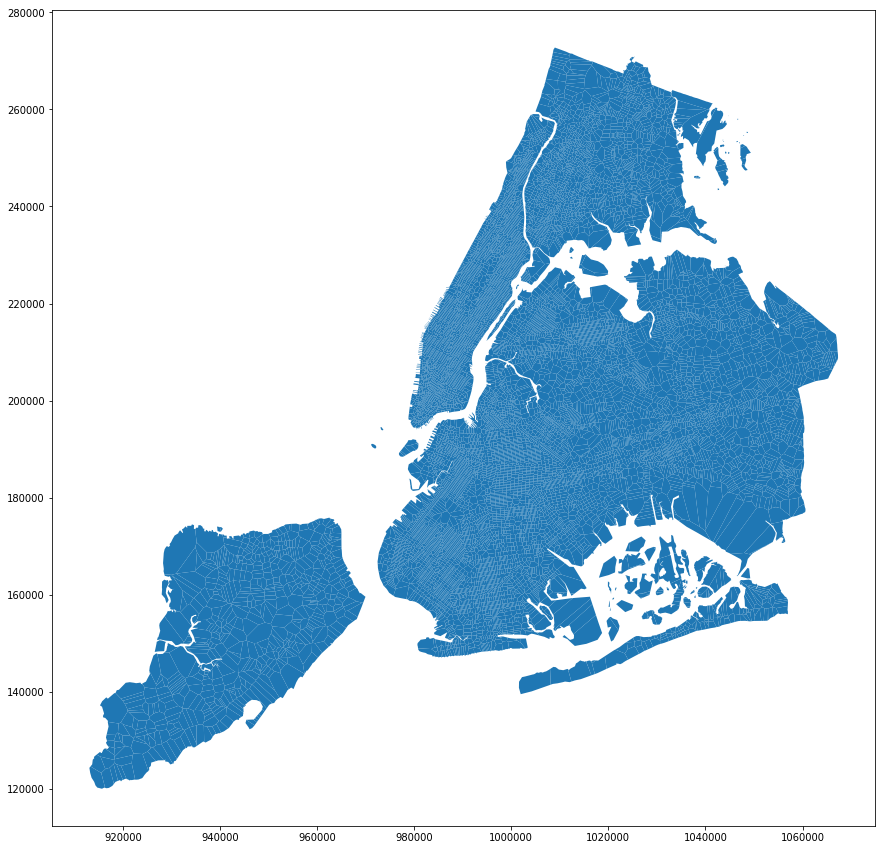

In [487]:
voronoi_sub_analytical_gdf.plot(figsize=(15, 15));

In [488]:
voronoi_sub_analytical_gdf.count()

bcode       13315
bname       13315
name        13315
namelsad    13315
geometry    13315
dtype: int64

In [493]:
voronoi_sub_analytical_gdf.columns

Index(['bcode', 'bname', 'name', 'namelsad', 'geometry'], dtype='object')

In [500]:
collapsed_analytical_gdf.columns

Index(['intersection_id', 'collision_count', 'personsinjured',
       'pedestriansinjured', 'cyclistinjured', 'motoristinjured',
       'flag_LPIS_ever', 'x', 'y', 'geometry'],
      dtype='object')

Problem: Recall that there were only 12987 counts previously, but now there is 13315. We will use `geopandas`'s `sjoin` to find polygons that intersect with the signal intersection points.

In [501]:
voronoi_intersections_collapsed_analytical_gdf = gpd.sjoin(voronoi_sub_analytical_gdf,collapsed_analytical_gdf, how='inner', op='intersects')

In [502]:
voronoi_intersections_sub_analytical_gdf['bcode'].count()

12983

In [503]:
print(voronoi_intersections_collapsed_analytical_gdf.columns.values)

['bcode' 'bname' 'name' 'namelsad' 'geometry' 'index_right'
 'intersection_id' 'collision_count' 'personsinjured' 'pedestriansinjured'
 'cyclistinjured' 'motoristinjured' 'flag_LPIS_ever' 'x' 'y']


It is suppose to be 12,987, but we only have 12983. The 4 intersections were lost because they are outside the boundaries of the boroughs.

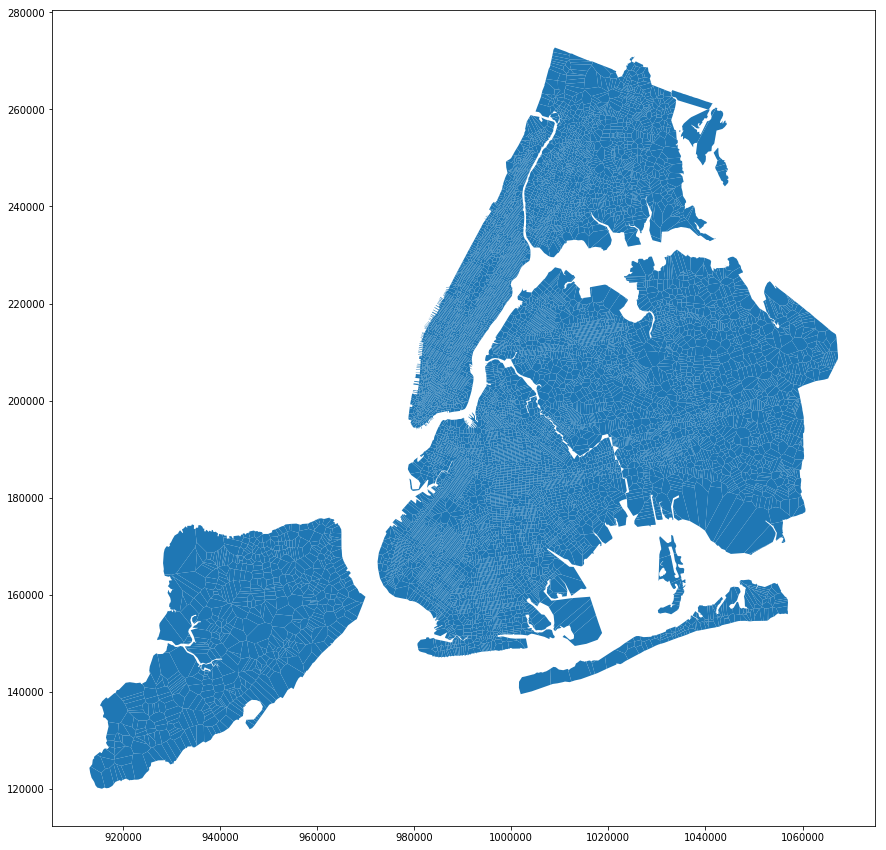

In [504]:
voronoi_intersections_collapsed_analytical_gdf.plot(figsize=(15, 15));

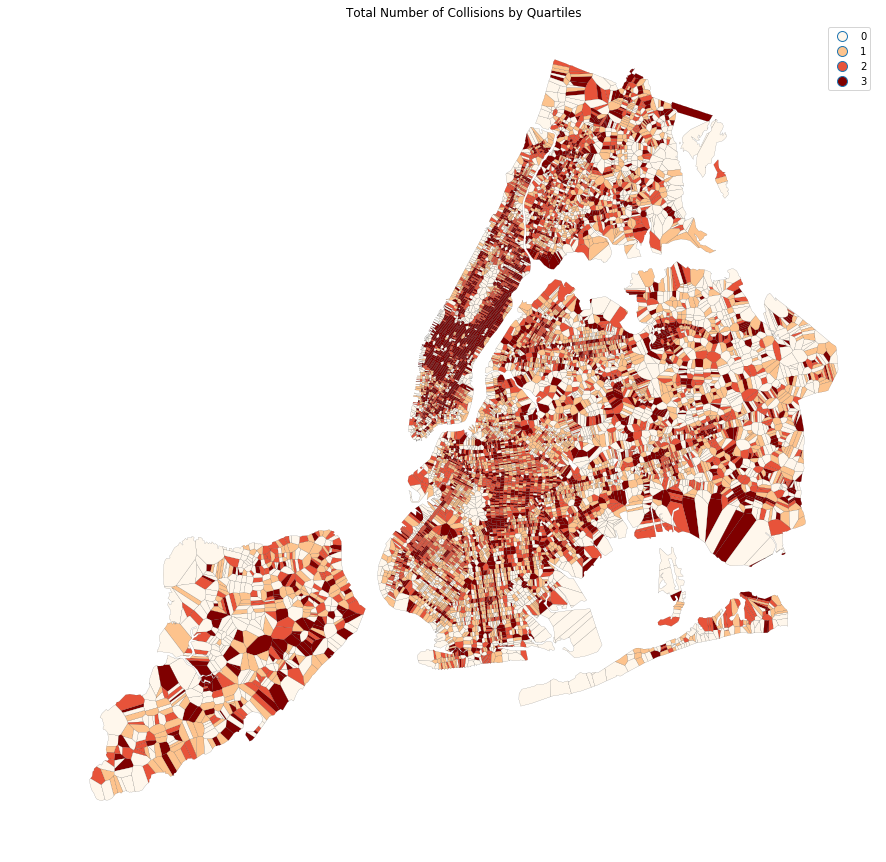

In [509]:
quantiles = ps.Quantiles(voronoi_intersections_collapsed_analytical_gdf['collision_count'], k=4)
f, ax = plt.subplots(1, figsize=(15, 15))
voronoi_intersections_collapsed_analytical_gdf.assign(cl=quantiles.yb).plot(column='cl', categorical=True, \
        k=4, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Total Number of Collisions by Quartiles")
plt.show();

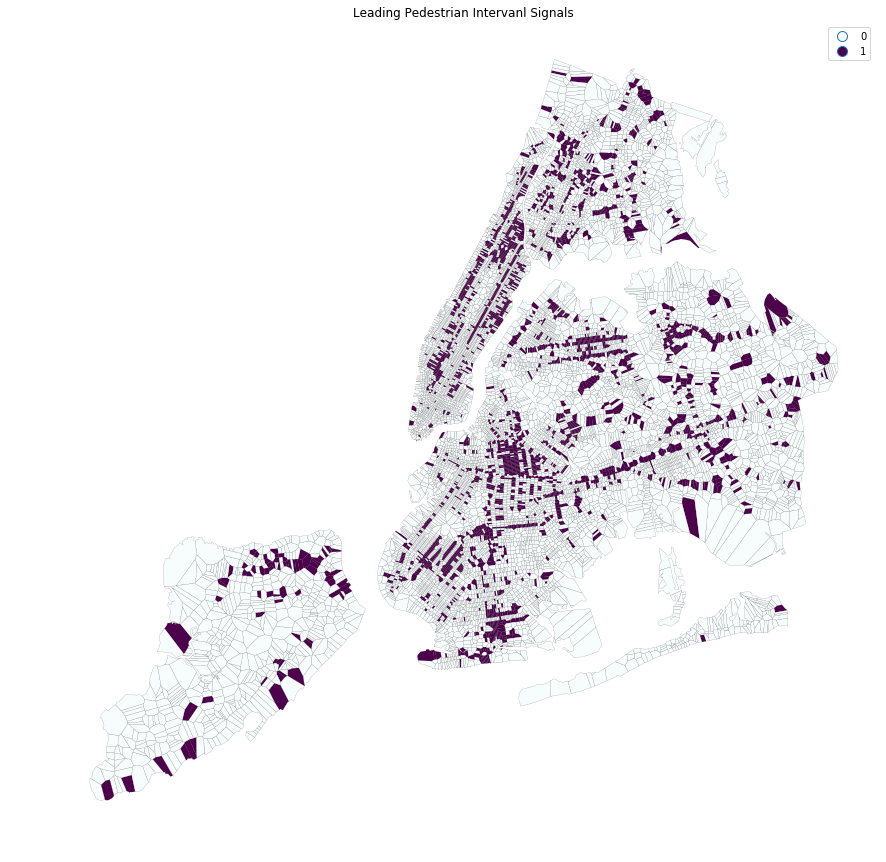

In [510]:
quantiles = ps.Quantiles(voronoi_intersections_collapsed_analytical_gdf['flag_LPIS_ever'], k=2)
f, ax = plt.subplots(1, figsize=(15, 15))
voronoi_intersections_collapsed_analytical_gdf.assign(cl=quantiles.yb).plot(column='cl', categorical=True, \
        k=4, cmap='BuPu', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Leading Pedestrian Intervanl Signals")
plt.show();

#### 8.b. Spatial Autocorrelation

"The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure."<br>
source: http://darribas.org/gds_scipy16/ipynb_md/04_esda.html

### 9. Non-spatial Analysis 
- stata


### 10. Spatial Analysis 
- stata